# 总览

目标：预测最细粒度的商品id30490个时间序列数据，属于多时间序列预测问题。
难点：最细粒度的销量趋势不明显，大量0值存在。
分析：大粒度的ID聚合销量序列呈现明显的年、季度、趋势等周期特整。如何将聚合的稳定趋势预测问题转化为细粒度趋势预测？
转化：
- 1. 计算聚合id下销量，并用Prophet预测聚合ID下28天的销量。
- 2. 计算真实销量，针对某一聚合品类，分别计算其对应的细粒度商品id的真实销量占该品类真实销量的比例R。
- 3. 转化未来1天的销量预测值 = R * 未来1天的该品类的聚合销量。

### 细节：

- 假设：聚合id为dept_id（部门id），则不同取值有7个品类（FOODS_1、FOODS_2、FOODS_3、HOBBIES_1、HOBBIES_2、HOUSEHOLD_1、HOUSEHOLD_2）。
- Prophet预测：得到7个时间序列（1-1914天）未来28天（1914-1941）的聚合销量数据。
- 问题：如何计算未来1天的某个商品id的销量？
- 详情：

    1、目标：预测品类FOODS_1下某一个商品id=id_x的1941th的销量。

    2、过程：

> 1）将品类=FOODS_1的原始销量数据全部拿出来，分别计算该品类下每个商品最近28天（1914th以前的28天）的销量和，并将商品id=id_x对应的销量和记为SUM1_idx1_FOODS1。计算该类目下最近28天所有商品的销量和为SUM2_FOODS1。则商品id_x1在该品类下的占比R_idx1_FOODS1 = SUM1_idx1_FOODS1 / SUM2_FOODS1。

> 2）Prophet预测品类=FOODS_1的一个聚合时间序列在1914的销量和Pre_FOODS1。

> 3）【id_x1在1914th的预测销量】= R_idx1_FOODS1 * Pre_FOODS1 = （SUM1_idx1_FOODS1 / SUM2_FOODS1）* Pre_FOODS1。

    【疑问1】：为什么1）中计算最近的28天销量和？用最近一天计算的id销量占比转移到未来一天（这里假设未来一天id销量占比与最近的占比一致）不可以吗？
    【答案】：案例来说可以。但是不稳定。最近一天商品id的销量计算带有不稳定性。因此计算的时间更长一些，也可以换成7、14等。
    
    【疑问2】：为什么前面这么大的篇幅都是处理数据形态，变成那么复杂的多索引？
    【答案】：数据量比较大，耗内存，其实主要是各种ID，将其转为多索引，减少内存，且增加查询效率。
    
    【疑问3】：不同的聚合ID选取的标准是什么？
    【答案】：源于官方的评价标准的说明，评价标准考察了这些聚合维度销量 + 最细粒度向量。在这里选择了9个level的聚合方向，也就是说我们可以预测9种提交结果。
    
    【疑问4】：这9种提交结果怎么处理？
    【答案】：分别提交查看结果好坏。或者将所有结果求平均提交。








In [1]:
# Models
# --------
# FBProphet
# Loader/fast aggregrations from: https://www.kaggle.com/christoffer/pandas-multi-indices-for-hts-fast-loading-etc

# FPBTD_v1 Level 9, LB=0.603
# yearly_seasonality=2 weekly_seasonality=1, n_changepoints = 50, LRMSE=12.128

# FPBTD_v2 - Levels 1 to 9
# yearly_seasonality=10 weekly_seasonality=3, n_changepoints = 50, US holidays added, LRMSE=11.824
# lag365, lag28_roll28 min and max

# FPBTD_v3 - Levels 1 to 5
# Same as previous with quarter_fourier_order=4, L6-L6=0.614

# FPBTD_v4 - Levels 1 to 9
# quarter_fourier_order=8 + cumulated price, L6-LB=0.616

# FPBTD_v5 - Levels 1 to 9
# quarter_fourier_order=6, outliers removed, L6-LB=0.637

# FPBTD_v6 - Levels 1 to 9
# quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.642

# FPBTD_v7 - Levels 1 to 9
# 2013, quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.61x

# FPBTD_v8 - Levels 1 to 9
# 2014, quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.63x

# FPBTD_v9 - Levels 1 to 9
# 2012, quarter_fourier_order=6, outliers removed + christmas, L6-LB=0.618

# FPBTD_v10 - Levels 1 to 9
# 2012, quarter_fourier_order=6, additional lags, L6-LB=

In [2]:
# !conda install -c conda-forge fbprophet

In [3]:
import os, sys, random, gc, math, glob, time
import numpy as np
import pandas as pd
import io, timeit, os, gc, pickle, psutil
import joblib
import time
from tqdm import tqdm
from matplotlib import cm
from datetime import datetime, timedelta
import warnings
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
from functools import partial
from collections import OrderedDict
# from tqdm.contrib.concurrent import process_map

# warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 4000)

In [4]:
# !pip install psutil

In [5]:
seed = 2020
random.seed(seed)
np.random.seed(seed)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
DEFAULT_FIG_WIDTH = 20
sns.set_context("paper", font_scale=1.2) 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, ShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import csv
from collections import defaultdict

#import lightgbm as lgb

print('Python    : ' + sys.version.split('\n')[0])
print('Numpy     : ' + np.__version__)
print('Pandas    : ' + pd.__version__)
#print('LightGBM  : ' + lgb.__version__)

Python    : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy     : 1.18.5
Pandas    : 1.0.5


In [8]:
# !pip install fbprophet --upgrade

In [9]:
import fbprophet
from fbprophet import Prophet
print('Prophet  : ' + fbprophet.__version__)

Importing plotly failed. Interactive plots will not work.


Prophet  : 0.6



### 数据说明

The data for the competition consists primarily of 30490 time series of sales data for 3049 items sold in 10 different stores in 3 states. The items are classified as being in one of 3 categories that are further subdivided into a total of 7 departments.

The representation we'll look at in this notebook is representing each individual time series as a column in a data frame indexed by the day (d).

For the individual (level 12 series), we'll index the series in the columns by (state_id, store_id, cat_id, dept_id, item_id).



- 竞争的数据主要包括30490个时间序列的销售数据，涉及3个州10个不同商店销售的3049种商品。这些商品被划分为3个类别中的一个，再进一步细分为共7个部门。

- 我们在这个笔记本中要看的表示方法是将每个单独的时间序列表示为一个数据框架中的一列，以日（d）为索引。

- 对于个体（12级系列），我们将在列中按（state_id，store_id，cat_id，dept_id，item_id）来索引系列。

总结：
- 行索引为日期
- 列索引为各种id

# 1. 创建数据

Using Pandas directly to read the data and reshape it appears to be a bit slow and uses a significant amount of memory. Instead we'll read the data line by line and store it in NumPy arrays (but we'll try and keep the rest of the code in the notebook nicely vectorized and high-level =).

直接使用Pandas来读取数据并重塑数据似乎有点慢，而且会使用大量的内存。取而代之的是，我们将逐行读取数据，并将其存储在NumPy数组中（但我们会尽量让笔记本中的其他代码保持很好的矢量化和高级化=）。

In [10]:
HOME =  "./"
DATA_HOME = "../data/"
TRAIN_DATA_HOME = DATA_HOME

CALENDAR = DATA_HOME + "calendar.csv"
SALES = DATA_HOME + "sales_train_validation.csv"
PRICES = DATA_HOME + "sell_prices.csv"

MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
            
NUM_SERIES = 30490
NUM_TRAINING = 1913
NUM_TEST = NUM_TRAINING + 2 * 28   # 初赛与复赛均是预测28天
MAX_LEVEL = 9 #9

In [11]:
# Load data
series_ids = np.empty(NUM_SERIES, dtype=object)
item_ids = np.empty(NUM_SERIES, dtype=object)
dept_ids = np.empty(NUM_SERIES, dtype=object)
cat_ids = np.empty(NUM_SERIES, dtype=object)
store_ids = np.empty(NUM_SERIES, dtype=object)
state_ids = np.empty(NUM_SERIES, dtype=object)

# 行为日期、列为各个商品
qties = np.zeros((NUM_TRAINING, NUM_SERIES), dtype=float) 
sell_prices = np.zeros((NUM_TEST, NUM_SERIES), dtype=float)

### 1.1 导入和重塑销售数据


- 逐行读取数据，同时将id与销量分裂开，放到不同的容器内。
- 销售数据中的每一行都由六个列组成，为一个系列的id，连同项目、部门、类别、商店、和、州五个层次。


In [12]:
# Sales
id_idx = {}
with open(SALES, "r", newline='') as f:
    is_header = True
    i = 0
    for row in tqdm(csv.reader(f)):
        if is_header:
            is_header = False
            continue
        series_id, item_id, dept_id, cat_id, store_id, state_id = row[0:6]
        # Remove '_validation/_evaluation' at end by regenerating series_id
        series_id = f"{item_id}_{store_id}"

        qty = np.array(row[6:], dtype=float)

        series_ids[i] = series_id

        item_ids[i] = item_id
        dept_ids[i] = dept_id
        cat_ids[i] = cat_id
        store_ids[i] = store_id
        state_ids[i] = state_id

        qties[:, i] = qty # 将一个商品的时间序列竖着放

        id_idx[series_id] = i # 哈希表————用序列号来编码30490个商品id

        i += 1
        
print('销量数据qties的shape为：', qties.shape)
print('销量数据商品HOBBIES_1_001_CA_1对应的编码id为：', id_idx['HOBBIES_1_001_CA_1'])

30491it [00:12, 2532.59it/s]

销量数据qties的shape为： (1913, 30490)
销量数据商品HOBBIES_1_001_CA_1对应的编码id为： 0


### 1.2 导入日历数据

日历数据有关于某一天是一周中的哪一天，是否有任何特殊事件的信息，最重要的是对于这个笔记本来说，这一天是在哪一周（wm_yr_wk）。我们需要这些来获得物品的价格，而这又是计算我们估算分数所需的权重所必需的。

- wm_yr_wk_idx：盛放周序号对应的第几天（每个周序号都有七天）


In [13]:
# Calendar
wm_yr_wk_idx = defaultdict(list)  # map wmyrwk to d:s
with open(CALENDAR, "r", newline='') as f:
    for row in tqdm(csv.DictReader(f)):
        d = int(row['d'][2:]) # 将d列中"d_1"的1剥离出来，重新设置为d
        wm_yr_wk_idx[row['wm_yr_wk']].append(d)
        
print('周序号="11101"，对应的七天为：')
print(wm_yr_wk_idx['11101'])

1969it [00:00, 108381.80it/s]

周序号="11101"，对应的七天为：
[1, 2, 3, 4, 5, 6, 7]


### 1.3 导入价格数据

The price data describes the weekly prices for each item in every store.


In [14]:
# Price
with open(PRICES, "r", newline='') as f:
    is_header = True
    for row in tqdm(csv.reader(f)):
        if is_header:
            is_header = False
            continue
        store_id, item_id, wm_yr_wk, sell_price = row
        series_id = f"{item_id}_{store_id}"
        series_idx = id_idx[series_id] # 从id_idx中召唤商品id对应的数字编码
        for d in wm_yr_wk_idx[wm_yr_wk]: # 从哈希表wm_yr_wk_idx中召唤出周序号=wm_yr_wk对应的哪些天
            # sell_prices每一列代表一个商品id对应的所有日期的价格
            sell_prices[d - 1, series_idx] = float(sell_price) 

print('价格数据sell_prices的shape为：', sell_prices.shape)
print('最后一个商品{series_id}对应的周{wm_yr_wk}平均价格 = {sell_price}'.format(series_id=series_id, 
                                                                  wm_yr_wk=wm_yr_wk, 
                                                                  sell_price=sell_price))

6841122it [00:42, 161524.64it/s]

价格数据sell_prices的shape为： (1969, 30490)
最后一个商品FOODS_3_827_WI_3对应的周11621平均价格 = 1.0


# 2. Building DataFrame

We'll store the dataset in two dataframes:

- qty_ts: sales data.
- price_ts: prices.
- 在这里构建数据框时，就体现了多层列索引的东西
- 设计的表为达宽表。行为日期，列为各种id的多级索引列。



In [15]:
# Aggregations - Levels
qty_ts = pd.DataFrame(qties,
                      index=range(1, NUM_TRAINING + 1),
                      columns=[state_ids, store_ids,
                               cat_ids, dept_ids, item_ids])

qty_ts.index.names = ['d']
qty_ts.columns.names = ['state_id', 'store_id',
                        'cat_id', 'dept_id', 'item_id']

print('===================================== 销量数据 =====================================')
print('输出qty_ts列的shape: ', qty_ts.shape)
print('输出qty_ts前两列的列名: \n', qty_ts.columns[:2])
price_ts = pd.DataFrame(sell_prices,
                        index=range(1, NUM_TEST + 1),
                        columns=[state_ids, store_ids,
                                 cat_ids, dept_ids, item_ids])
price_ts.index.names = ['d']
price_ts.columns.names = ['state_id', 'store_id',
                          'cat_id', 'dept_id', 'item_id']

print('===================================== 价格数据 =====================================')
print('输出price_ts列的shape: ', price_ts.shape)
print('输出price_ts前两列的列名: \n', price_ts.columns[:2])

===================================== 销量数据 =====================================
输出qty_ts列的shape:  (1913, 30490)
输出qty_ts前两列的列名: 
 MultiIndex([('CA', 'CA_1', 'HOBBIES', 'HOBBIES_1', 'HOBBIES_1_001'),
            ('CA', 'CA_1', 'HOBBIES', 'HOBBIES_1', 'HOBBIES_1_002')],
           names=['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'])
===================================== 价格数据 =====================================
输出price_ts列的shape:  (1969, 30490)
输出price_ts前两列的列名: 
 MultiIndex([('CA', 'CA_1', 'HOBBIES', 'HOBBIES_1', 'HOBBIES_1_001'),
            ('CA', 'CA_1', 'HOBBIES', 'HOBBIES_1', 'HOBBIES_1_002')],
           names=['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'])



# 3. 聚合

### LEVELS

- 在这次比赛中，我们的模型在12个不同的层次上进行评估，这些层次是由系列的分组组合定义的。
- 重要的是，我们可以汇总我们的时间序列，例如，计算每个州的总销售额，这样我们就可以评估模型在每个级别上的每店商品销售数据预测。

### COARSER

- Pandas将所有的列级都看作是独立的，但在这里并不是，例如，所有具有相同dept_id的系列都属于同一个cat_id。当我们对列进行分组时，我们也会保留任何较粗的分组。

In [16]:
LEVELS = {
    1: [],
    2: ['state_id'],
    3: ['store_id'],
    4: ['cat_id'],
    5: ['dept_id'],
    6: ['state_id', 'cat_id'],
    7: ['state_id', 'dept_id'],
    8: ['store_id', 'cat_id'],
    9: ['store_id', 'dept_id'],
    10: ['item_id'],
    11: ['state_id', 'item_id'],
    12: ['item_id', 'store_id']
}

COARSER = {
    'state_id': [],
    'store_id': ['state_id'],
    'cat_id': [],
    'dept_id': ['cat_id'],
    'item_id': ['cat_id', 'dept_id']
}

In [17]:
COARSER

{'state_id': [],
 'store_id': ['state_id'],
 'cat_id': [],
 'dept_id': ['cat_id'],
 'item_id': ['cat_id', 'dept_id']}

In [18]:
def aggregate_all_levels(df):
    levels = []
    for i in range(1, max(LEVELS.keys()) + 1):
        level = aggregate_groupings(df, i, *LEVELS[i])
        levels.append(level)
    return pd.concat(levels, axis=1)

def aggregate_groupings(df, level_id, grouping_a=None, grouping_b=None):
    """Aggregate time series by summing over optional levels

    New columns are named according to the m5 competition.

    :param df: Time series as columns
    :param level_id: Numeric ID of level
    :param grouping_a: Grouping to aggregate over, if any
    :param grouping_b: Additional grouping to aggregate over, if any
    :return: Aggregated DataFrame with columns as series id:s
    """
    if grouping_a is None and grouping_b is None:
        new_df = df.sum(axis=1).to_frame()
    elif grouping_b is None:
        new_df = df.groupby(COARSER[grouping_a] + [grouping_a], axis=1).sum()
    else:
        assert grouping_a is not None
        new_df = df.groupby(COARSER[grouping_a] + COARSER[grouping_b] +
                            [grouping_a, grouping_b], axis=1).sum()

    new_df.columns = _restore_columns(df.columns, new_df.columns, level_id,
                                      grouping_a, grouping_b)
    return new_df

一个小的复杂情况是，Pandas在列的连通过程中并不对齐，即如果两个数据框有一些不同的列级别，pd.concat并不匹配帧之间相同的级别。

最简单的解决方法就是暂时把我们分组后丢失的级别加回来。

In [19]:
def _restore_columns(original_index, new_index, level_id, grouping_a, grouping_b):
    original_df = original_index.to_frame()
    new_df = new_index.to_frame()
    for column in original_df.columns:
        if column not in new_df.columns:
            new_df[column] = None

    # Set up `level` column
    new_df['level'] = level_id

    # Set up `id` column
    if grouping_a is None and grouping_b is None:
        new_df['id'] = 'Total_X'
    elif grouping_b is None:
        new_df['id'] = new_df[grouping_a] + '_X'
    else:
        assert grouping_a is not None
        new_df['id'] = new_df[grouping_a] + '_' + new_df[grouping_b]

    new_index = pd.MultiIndex.from_frame(new_df)
    # Remove "unnamed" level if no grouping
    if grouping_a is None and grouping_b is None:
        new_index = new_index.droplevel(0)
    new_levels = ['level'] + original_index.names + ['id']
    return new_index.reorder_levels(new_levels)

In [20]:
agg_pd = aggregate_all_levels(qty_ts)
agg_pd.head()

level          1        2                       3                           \
state_id      NaN       CA      TX      WI      CA                           
store_id      NaN      NaN     NaN     NaN    CA_1    CA_2    CA_3    CA_4   
cat_id        NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
dept_id       NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
item_id       NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
id        Total_X     CA_X    TX_X    WI_X  CA_1_X  CA_2_X  CA_3_X  CA_4_X   
d                                                                            
1         32631.0  14195.0  9438.0  8998.0  4337.0  3494.0  4739.0  1625.0   
2         31749.0  13805.0  9630.0  8314.0  4155.0  3046.0  4827.0  1777.0   
3         23783.0  10108.0  6778.0  6897.0  2816.0  2121.0  3785.0  1386.0   
4         25412.0  11047.0  7381.0  6984.0  3051.0  2324.0  4232.0  1440.0   
5         19146.0   9925.0  5912.0  3309.0  2630.0  1942.0  3817.0  1536.0   

level                                                          4             \
state_id      TX                      WI                      NaN             
store_id    TX_1    TX_2    TX_3    WI_1    WI_2    WI_3      NaN             
cat_id       NaN     NaN     NaN     NaN     NaN     NaN    FOODS   HOBBIES   
dept_id      NaN     NaN     NaN     NaN     NaN     NaN      NaN       NaN   
item_id      NaN     NaN     NaN     NaN     NaN     NaN      NaN       NaN   
id        TX_1_X  TX_2_X  TX_3_X  WI_1_X  WI_2_X  WI_3_X  FOODS_X HOBBIES_X   
d                                                                             
1         2556.0  3852.0  3030.0  2704.0  2256.0  4038.0  23178.0    3764.0   
2         2687.0  3937.0  3006.0  2194.0  1922.0  4198.0  22758.0    3357.0   
3         1822.0  2731.0  2225.0  1562.0  2018.0  3317.0  17174.0    2682.0   
4         2258.0  2954.0  2169.0  1251.0  2522.0  3211.0  18878.0    2669.0   
5         1694.0  2492.0  1726.0     2.0  1175.0  2132.0  14603.0    1814.0   

level                       5                                               \
state_id                   NaN                                               
store_id                   NaN                                               
cat_id     HOUSEHOLD     FOODS                         HOBBIES               
dept_id          NaN   FOODS_1   FOODS_2   FOODS_3   HOBBIES_1   HOBBIES_2   
item_id          NaN       NaN       NaN       NaN         NaN         NaN   
id       HOUSEHOLD_X FOODS_1_X FOODS_2_X FOODS_3_X HOBBIES_1_X HOBBIES_2_X   
d                                                                            
1             5689.0    2343.0    4094.0   16741.0      3610.0       154.0   
2             5634.0    2216.0    4209.0   16333.0      3172.0       185.0   
3             3927.0    1657.0    3174.0   12343.0      2497.0       185.0   
4             3865.0    1508.0    3606.0   13764.0      2531.0       138.0   
5             2729.0    1209.0    2869.0   10525.0      1714.0       100.0   

level                                      6                           \
state_id                                   CA                           
store_id                                  NaN                           
cat_id       HOUSEHOLD                  FOODS    HOBBIES    HOUSEHOLD   
dept_id    HOUSEHOLD_1   HOUSEHOLD_2      NaN        NaN          NaN   
item_id            NaN           NaN      NaN        NaN          NaN   
id       HOUSEHOLD_1_X HOUSEHOLD_2_X CA_FOODS CA_HOBBIES CA_HOUSEHOLD   
d                                                                       
1               4105.0        1584.0  10101.0     1802.0       2292.0   
2               3858.0        1776.0   9862.0     1561.0       2382.0   
3               2827.0        1100.0   6944.0     1472.0       1692.0   
4               2732.0        1133.0   7864.0     1405.0       1778.0   
5               1802.0         927.0   7178.0     1181.0       156

In [21]:
# All levels
df_train = agg_pd.T.reset_index()
df_train = df_train.set_index("id") # id as index
rename_dict = {}
for c in df_train.columns:
    if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']:
        rename_dict[c] = "d_%s" % c
df_train.rename(columns=rename_dict, inplace=True)
day_cols = pd.Series([c for c in df_train.columns if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']]) # d_1 to d_1913
print(df_train.shape)
df_train.head()

(42840, 1919)


d        level state_id store_id cat_id dept_id item_id      d_1      d_2  \
id                                                                          
Total_X      1      NaN      NaN    NaN     NaN     NaN  32631.0  31749.0   
CA_X         2       CA      NaN    NaN     NaN     NaN  14195.0  13805.0   
TX_X         2       TX      NaN    NaN     NaN     NaN   9438.0   9630.0   
WI_X         2       WI      NaN    NaN     NaN     NaN   8998.0   8314.0   
CA_1_X       3       CA     CA_1    NaN     NaN     NaN   4337.0   4155.0   

d            d_3      d_4      d_5      d_6      d_7      d_8      d_9  \
id                                                                       
Total_X  23783.0  25412.0  19146.0  29211.0  28010.0  37932.0  32736.0   
CA_X     10108.0  11047.0   9925.0  11322.0  12251.0  16610.0  14696.0   
TX_X      6778.0   7381.0   5912.0   9006.0   6226.0   9440.0   9376.0   
WI_X      6897.0   6984.0   3309.0   8883.0   9533.0  11882.0   8664.0   
CA_1_X    2816.0   3051.0   2630.0   3276.0   3450.0   5437.0   4340.0   

d           d_10     d_11     d_12     d_13     d_14     d_15     d_16  \
id                                                                       
Total_X  25572.0  23071.0  23658.0  23756.0  26445.0  34833.0  36380.0   
CA_X     11822.0  10933.0  10350.0  11204.0  11354.0  14610.0  15630.0   
TX_X      7319.0   6224.0   6740.0   6109.0   7202.0  10081.0  11725.0   
WI_X      6431.0   5914.0   6568.0   6443.0   7889.0  10142.0   9025.0   
CA_1_X    3157.0   2995.0   2710.0   2928.0   3078.0   4316.0   4354.0   

d           d_17     d_18     d_19     d_20     d_21     d_22     d_23  \
id                                                                       
Total_X  21804.0  24070.0  21443.0  20318.0  23721.0  31689.0  29283.0   
CA_X      9044.0   9496.0   8844.0   7835.0  10025.0  13870.0  13465.0   
TX_X      6719.0   7460.0   6606.0   6412.0   6711.0   9150.0   9789.0   
WI_X      6041.0   7114.0   5993.0   6071.0   6985.0   8669.0   6029.0   
CA_1_X    2757.0   2430.0   2272.0   2009.0   3015.0   4553.0   3966.0   

d           d_24     d_25     d_26     d_27     d_28     d_29     d_30  \
id                                                                       
Total_X  23966.0  20501.0  20757.0  20277.0  22529.0  29908.0  28707.0   
CA_X     11997.0   9130.0   8941.0   8514.0   9847.0  13652.0  12491.0   
TX_X      7297.0   6628.0   5814.0   6175.0   6286.0   8586.0   9086.0   
WI_X      4672.0   4743.0   6002.0   5588.0   6396.0   7670.0   7130.0   
CA_1_X    3264.0   2441.0   2377.0   2414.0   2701.0   3719.0   3548.0   

d           d_31     d_32     d_33     d_34     d_35     d_36     d_37  \
id                                                                       
Total_X  21240.0  22872.0  22046.0  23475.0  23572.0  31202.0  34876.0   
CA_X      9196.0   9782.0   9537.0   9710.0  10444.0  13784.0  16057.0   
TX_X      6555.0   7082.0   6145.0   6639.0   6584.0   9238.0  10423.0   
WI_X      5489.0   6008.0   6364.0   7126.0   6544.0   8180.0   8396.0   
CA_1_X    2246.0   2549.0   2559.0   2568.0   2978.0   4096.0   4832.0   

d           d_38     d_39     d_40     d_41     d_42     d_43     d_44  \
id                                                                       
Total_X  24562.0  22752.0  22560.0  22626.0  25572.0  32225.0  31417.0   
CA_X     10953.0  10299.0   9951.0  10012.0  11189.0  13710.0  14340.0   
TX_X      7623.0   6335.0   6941.0   6339.0   7203.0   9271.0   9542.0   
WI_X      5986.0   6118.0   5668.0   6275.0   7180.0   9244.0   7535.0   
CA_1_X    3138.0   2997.0   2772.0   2650.0   3249.0   4114.0   4094.0   

d           d_45     d_46     d_47     d_48     d_49     d_50     d_51  \
id                                                                       
Total_X  24935.0  24021.0  22765.0  21779.0  23855.0  30599.0  29643.0   
CA_X     10722.0   9293.0   9752.0   9504.0  10030.0  14509.0  14112.0   
TX_X      7745.0   7834.0   6768.0   6759.0   7131

In [22]:
# agg_price_pd = aggregate_all_levels(price_ts)
# agg_price_pd.head()

In [23]:
# df_train_price = agg_price_pd.T.reset_index()
# df_train_price = df_train_price.set_index("id") # id as index
# rename_dict = {}
# for c in df_train_price.columns:
#     if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']:
#         rename_dict[c] = "d_%s" % c
# df_train_price.rename(columns=rename_dict, inplace=True)
# day_prices_cols = pd.Series([c for c in df_train_price.columns if c not in ['level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']]) # d_1 to d_1913+
# print(df_train_price.shape)
# df_train_price.head()

In [24]:
# Level 12 only
df_sale = df_train[df_train["level"] == 12]
df_sale.shape

(30490, 1919)

In [25]:
# Levels <= 9
df_train = df_train[df_train["level"] <= MAX_LEVEL]
print(df_train.shape)

(154, 1919)


In [26]:
# df_train_price = df_train_price[df_train_price["level"] <= MAX_LEVEL]
# print(df_train_price.shape)

Prepare data for Prophet

In [27]:
# Prepare calendar columns
df_calendar = pd.read_csv(CALENDAR)
df_calendar.index = df_calendar['d'].values # d_xxx as index
df_calendar['ds'] = pd.to_datetime(df_calendar['date']) # move date as datetime in "ds" column
df_calendar['quarter'] = df_calendar['ds'].dt.quarter # add quarter feature
df_calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
d_1  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
d_2  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
d_3  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
d_4  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
d_5  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

    event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  \
d_1          NaN          NaN          NaN        0        0        0   
d_2          NaN          NaN          NaN        0        0        0   
d_3          NaN          NaN          NaN        0        0        0   
d_4          NaN          NaN          NaN        1        1        0   
d_5          NaN          NaN          NaN        1        0        1   

            ds  quarter  
d_1 2011-01-29        1  
d_2 2011-01-30        1  
d_3 2011-01-31        1  
d_4 2011-02-01        1  
d_5 2011-02-02        1

In [28]:
# Generate holidays ds
events1 = pd.Series(df_calendar['event_name_1'].values, index=df_calendar['ds'].values).dropna()
events2 = pd.Series(df_calendar['event_name_2'].values, index=df_calendar['ds'].values).dropna()
holidays = pd.DataFrame(pd.concat([events1, events2], axis=0))
holidays['ds'] = holidays.index.values
holidays.rename({0: 'holiday'}, axis=1, inplace=True)
holidays.reset_index(drop=True, inplace=True)
del events1, events2
holidays.head()

holiday         ds
0      SuperBowl 2011-02-06
1  ValentinesDay 2011-02-14
2  PresidentsDay 2011-02-21
3      LentStart 2011-03-09
4      LentWeek2 2011-03-16

In [29]:
# Clean data: remove leading zeros and outliers
def clean_data(df_train, day_cols, indx):
    t = df_train.loc[indx].copy()
    t.loc[day_cols[((t.loc[day_cols]>0).cumsum()==0).values]] = np.nan
    q1 = t.loc[day_cols].quantile(0.25)
    q3 = t.loc[day_cols].quantile(0.75)
    iqr = q3-q1
    qm = (q3+1.5*iqr)
    t.loc[day_cols][t.loc[day_cols]>qm] = qm
    return t

In [30]:
future_preds = 28
day_fit_cols = day_cols

In [31]:
# Remove noticeable dates that are not in evaluation
ignore_dates = ["2011-12-25", "2012-12-25", "2013-12-25", "2014-12-25", "2015-12-25",
                "2011-12-24", "2012-12-24", "2013-12-24", "2014-12-24", "2015-12-24",
                "2011-12-31", "2012-12-31", "2013-12-31", "2014-12-31", "2015-12-31",
                "2012-01-01", "2013-01-01", "2014-01-01", "2015-01-01", "2016-01-01"]
ignore_days = [] # df_calendar[df_calendar['ds'].isin(ignore_dates)]["d"].apply(lambda x: int(x[2:])).values

In [32]:
FIRST = 338 # 1069 # 704 # 1 # 704
day_fit_cols = ["d_%d"%c for c in range(FIRST, 1914) if c not in ignore_days]
df_train = df_train[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'level'] + day_fit_cols]
df_calendar = df_calendar[df_calendar["d"].isin(["d_%d"%c for c in range(FIRST, 1942) if c not in ignore_days])]
#df_prices = df_prices[["d_%d"%c for c in range(FIRST, 1942) if c not in ignore_days]]

# 4. Prophet聚合数据预测



#### 关于Prophet预测的数据形式和参数含义

- 使用add_regressor方法将附加的回归量添加到模型的线性部分
- 输出

========================= y列增加28天的预测为nan =========================
(1604, 5)
============================== y列滞后项 ==============================
(1604, 11)
============================== df.columns ==============================
Index(['ds', 'month', 'wday', 'quarter', 'y', 'ft_lag28', 'ft_lag35',
       'ft_lag42', 'ft_lag28_roll28_std', 'ft_lag28_roll28_max',
       'ft_lag28_roll28_min'],
      dtype='object')
target_first_valid_index:  d_338
训练开始 ------------------------------------------------------------------
预测开始 ------------------------------------------------------------------
============================== 预测结果 ==============================
(1604, 63)
Average LRMSE=0.000


### 4.1 预测模型定义

In [33]:
# df_train: "id" ["d_1", "d_2", ...]
# holidays: ["holiday", "ds"]
# df_calendar d ["date", "ds", "weekday", "wday", "month", "year", "quarter" ...]
# df_prices: "id" ["d_1", "d_2", ...]
def make_prediction(indx, model_columns = 'yhat', ret_columns = 'yhat', full_predict = True):
    global df_train, holidays, df_calendar # df_train_price, df_prices
    # full_predict = True
    # Return either series or dataframe
    # model_columns = 'yhat' # ["yhat", "yhat_lower", "yhat_upper"]  # 'yhat' ["yhat"]
    # ret_columns = model_columns # + ["ds", "y"]
    changepoints=list()
    uncertainty_samples=False # False (True to include yhat_upper ...)
    changepoint_prior_scale=0.1
    changepoint_range=0.9
    n_changepoints=50
    holidays_prior_scale=10
    yearly_seasonality=10 #2
    weekly_seasonality=3 #1
    daily_seasonality=False
    monthly_fourier_order=8
    quarter_fourier_order=6 # 6 #None
    seasonality_prior_scale=10
    seasonality_mode = 'multiplicative'  # 'additive' 两种模式，默认情况下是加法模式
    
    target = df_train.loc[indx, day_fit_cols] # sales for one time series
    # target_price = df_train_price.loc[indx, day_prices_cols] # day_fit_cols

    snap_state_id = str(df_train.loc[indx, 'state_id'])
    cols = ['ds', 'month', 'wday', 'quarter']
    if snap_state_id in ["CA", "TX", "WI"]:
        cols = cols + ['snap_'+snap_state_id]

    # Create temporary dataframe for prediction from 2011-01-29	to 2016-05-22 (d_1941) initialized with NaN for values to predict
    # ["ds", "y", "prices", "month", "wday", "quarter", "snap_xx"] (snap matching to state related to id)
    df = df_calendar.iloc[:target.shape[0]+future_preds][cols].copy()
    df['y'] = target
    # print('========================= y列增加28天的预测为nan =========================')
    # print(df.shape)
    # print(df.tail())
    
    # Clip outliers in aggregated time series
    #q1 = df['y'].quantile(0.25)
    #q3 = df['y'].quantile(0.75)
    #iqr = q3-q1
    #qm_up = (q3+1.5*iqr)
    #qm_dw = (q1-1.5*iqr)
    #df.loc[df["y"] > qm_up, "y"] = qm_up
    #df.loc[df["y"] < qm_dw, "y"] = qm_dw
    
    #df['ft_lag365'] = df['y'].shift(365)
    #df["ft_lag365"].fillna(method ='bfill', inplace = True)
    df['ft_lag28'] = df['y'].shift(28)
    df["ft_lag28"].fillna(method ='bfill', inplace = True)
    df['ft_lag35'] = df['y'].shift(35)
    df["ft_lag35"].fillna(method ='bfill', inplace = True)
    df['ft_lag42'] = df['y'].shift(42)
    df["ft_lag42"].fillna(method ='bfill', inplace = True)
    df['ft_lag28_roll28_std'] = df['y'].shift(28).rolling(28).std()
    df["ft_lag28_roll28_std"].fillna(method ='bfill', inplace = True)
    df['ft_lag28_roll28_max'] = df['y'].shift(28).rolling(28).max()
    df["ft_lag28_roll28_max"].fillna(method ='bfill', inplace = True)
    df['ft_lag28_roll28_min'] = df['y'].shift(28).rolling(28).min()
    df["ft_lag28_roll28_min"].fillna(method ='bfill', inplace = True)
    # Add prices
    #df['prices'] = target_price.astype(np.float32)
    #df["prices"].fillna(method ='bfill', inplace = True)
    #df['ft_prices_roll7_std'] = df['prices'].rolling(7).std()
    #df["ft_prices_roll7_std"].fillna(method ='bfill', inplace = True)    

    # print('============================== y列滞后项 ==============================')
    # print(df.shape)
    # print(df.tail())
    
    # 相关参数解释见：
    # https://blog.csdn.net/anshuai_aw1/article/details/83412058 比较全的讲解Prophet的中文文档
    # https://blog.csdn.net/Joely_112/article/details/100090176  一些重要的Prophet参数调节说明
    # https://www.pianshen.com/article/3525122198/ 讲解也是蛮细的
    # https://zhuanlan.zhihu.com/p/33189135
    # https://zr9558.com/2018/11/30/timeseriespredictionfbprophet/
    GROWTH = 'linear' #'logistic' #'linear'
    m = Prophet(growth=GROWTH, 
                # holidays是节假日信息输入，holiday是一个文件，里面包含有节假日的信息
                # 存在突增、突降时使用。降低整体预测偏差
                holidays=holidays, 
                
                # yearly_seasonality 是年规律拟合，Prophet模型会描绘出以一年为单位的数据规律；
                # 同理于参数 weekly_seasonality，daily_seasonality
                yearly_seasonality=yearly_seasonality,
                daily_seasonality=daily_seasonality, 
                weekly_seasonality=weekly_seasonality,
                
                # changepoint_range 是设定转折点可以存在的范围，0.1表示存在于历史数据的前十分之一，
                # 0.5表示在历史数据的前半部分，其余同理。
                # changepoints=[] 是指定转折点的具体位置，指定转折点的具体位置，没有模型自适应拟合得好。
                changepoint_range=changepoint_range,
                
                # 调整趋势的灵活性。
                changepoint_prior_scale=changepoint_prior_scale, 
                
                # 转折点的数量，需要调整
                n_changepoints = n_changepoints,
                
                # uncertainty_samples：用于估计未来时间的增长趋势间隔的仿真绘制数，默认值：1000。
                uncertainty_samples=uncertainty_samples, 
                
                # holidays_prior_scale（holidays模型中的）：调节节假日模型组件的强度。
                # 值越大，该节假日对模型的影响越大，值越小，节假日的影响越小，默认值：10.0。
                holidays_prior_scale=holidays_prior_scale, 

                # 使用seasonality_mode ='multiplicative'，假日效果将被建模为乘法。
                # 默认情况下，任何添加的季节性或额外的回归量都将使用设置的seasonality_mode，
                # 但可以通过在添加季节性或回归量时指定mode ='additive’或mode ='multiplicative’作为参数来覆盖。
                seasonality_mode=seasonality_mode, 
                seasonality_prior_scale=seasonality_prior_scale)
    
    m.add_country_holidays(country_name='US')

    if not monthly_fourier_order is None:
        m.add_seasonality(name='monthly', period=365.25/12, fourier_order=monthly_fourier_order)
    if not quarter_fourier_order is None:
        m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=quarter_fourier_order)

    # Add regressor for month, wday, quarter (snap_XX, prices)
    # print('============================== df.columns ==============================')
    # print(df.columns)
    for reg in df.columns:
        if reg not in ['ds', 'y']:
            # 增加要回归数据的特征列，可以使用add_regressor方法将附加的回归量添加到模型的线性部分。
            # 重要地方！！！！！！！！！！！！！！！！！！
            m.add_regressor(reg)

    target_first_valid_index = target.first_valid_index()
    # print('target_first_valid_index: ', target_first_valid_index)

    if GROWTH == "logistic":
        df["cap"] = df["y"].max()
        df["floor"] = df["y"].min()
        
    # Fit on existing data (first_valid_index = Return index for first non-NA/null value.)
    
    # print('训练开始 ------------------------------------------------------------------')
    m.fit(df.loc[target.loc[target_first_valid_index:].index])

    # Remove target
    if 'y' not in ret_columns:
        df.drop(['y'], axis=1, inplace=True)

    res = None
    if full_predict == True:
        # print('预测开始 ------------------------------------------------------------------')
        forecast = m.predict(df.loc[target_first_valid_index:]) # For all days with valid data
        # print('============================== 预测结果 ==============================')
        # print(forecast.shape)
        # print(forecast.head())
        
        forecast["yhat"] = forecast["yhat"].astype(np.float32)
        res = forecast[model_columns]
        # Update prediction from first valid index from 2016-05-22
        res.index = df.loc[target_first_valid_index:].index.values
        res = df.merge(res, left_index=True, right_index=True, how="left")[ret_columns]

    else:
        forecast = m.predict(df.iloc[-future_preds:]) # for last 28 days (2016-04-25 to 2016-05-22)
        forecast["yhat"] = forecast["yhat"].astype(np.float32)
        res = forecast[model_columns]
        # Update prediction index from d_1914 to d_1941
        res.index = df.iloc[-future_preds:].index.values

    return (indx, res)

### 4.2 预测一部分按照ID聚合之后的时间序列看看情况

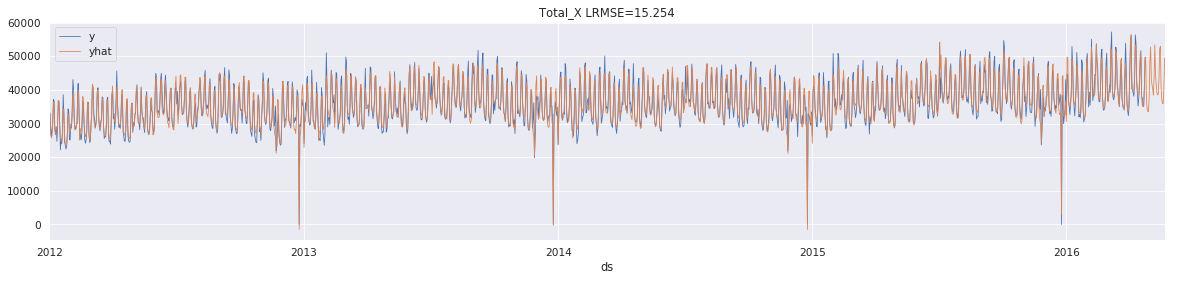

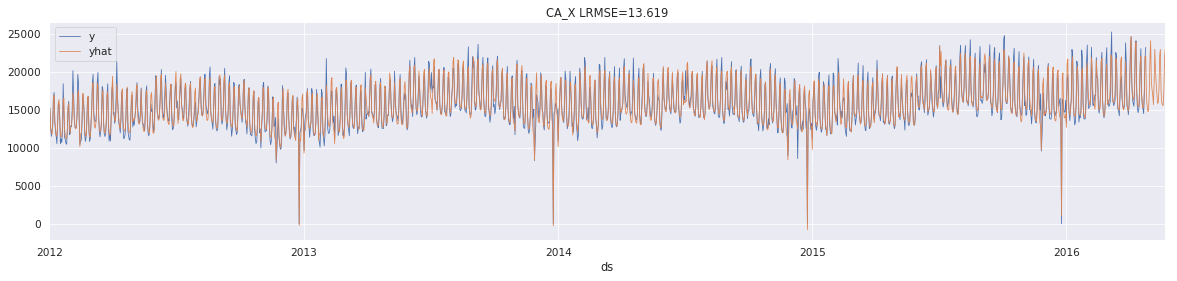

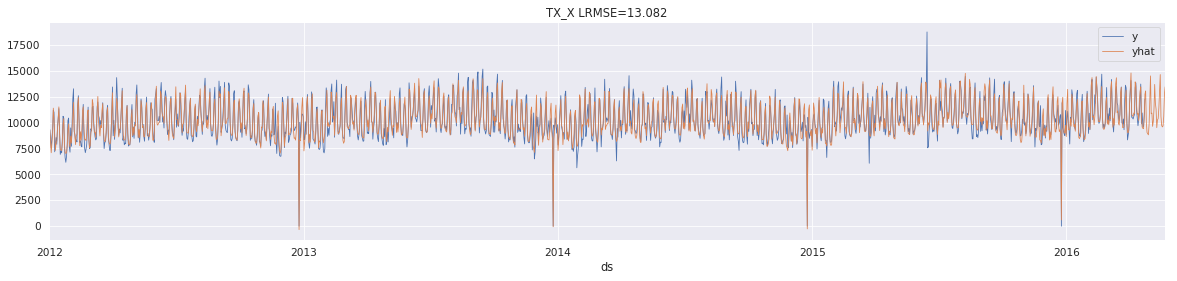

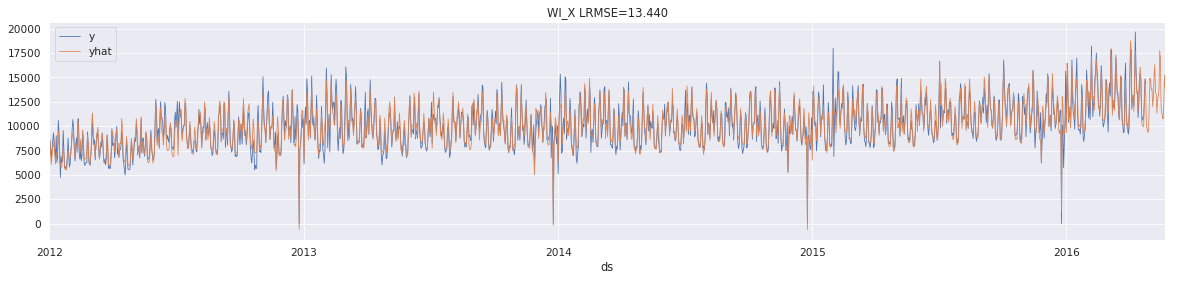

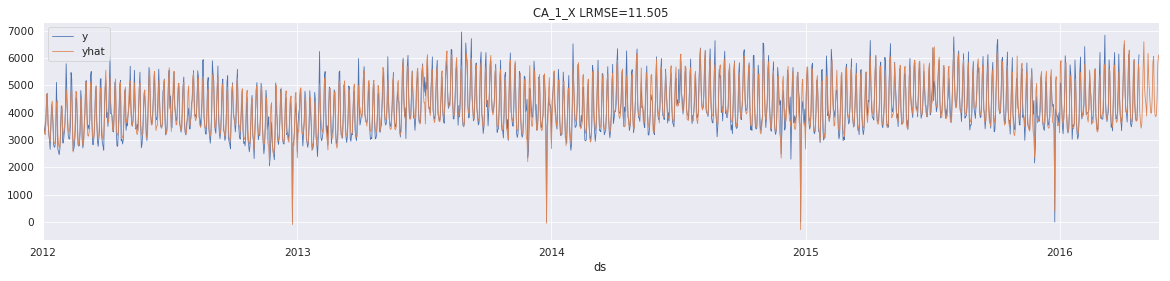

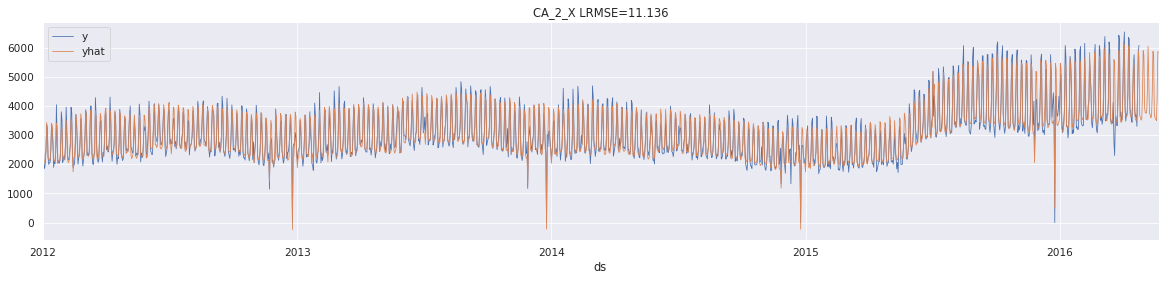

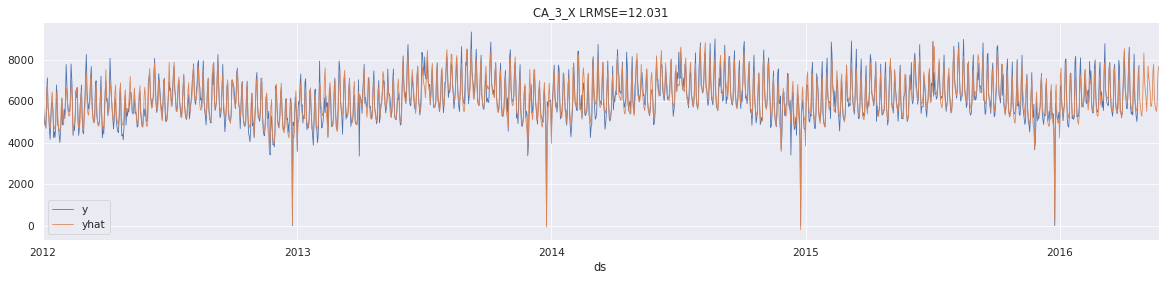

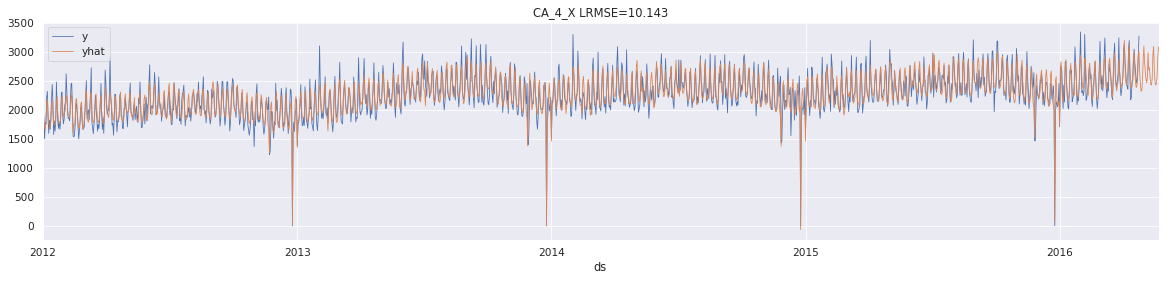

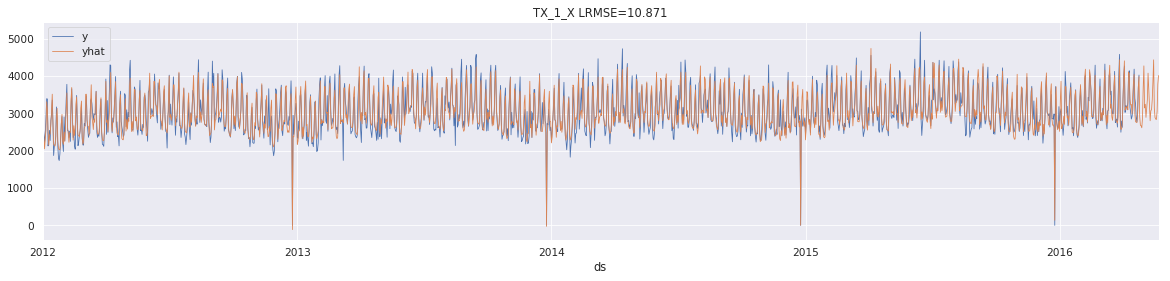

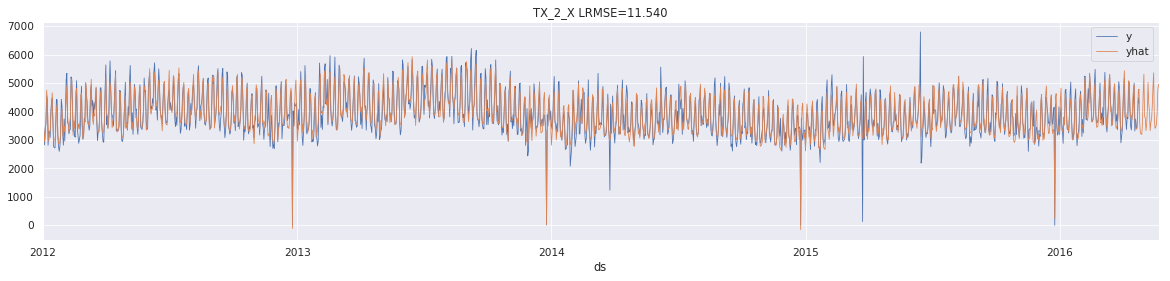

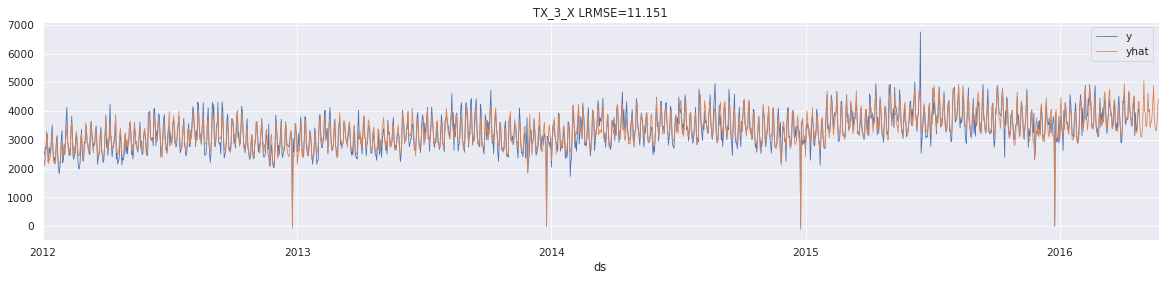

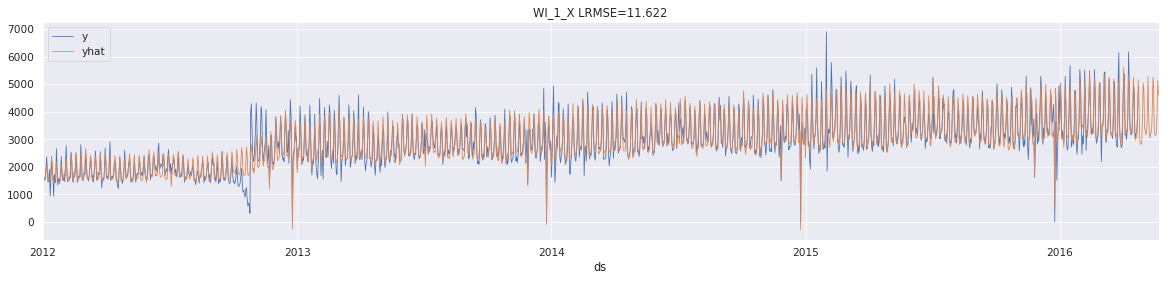

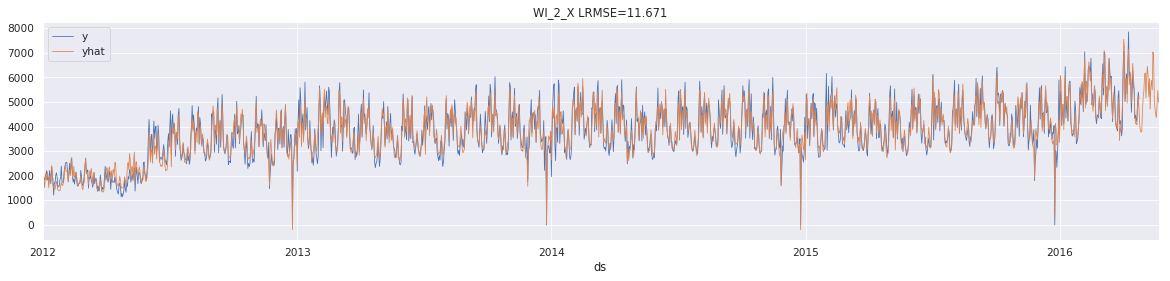

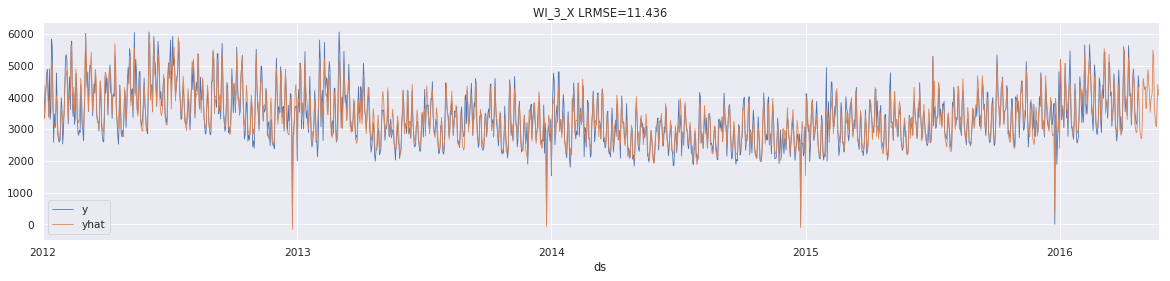

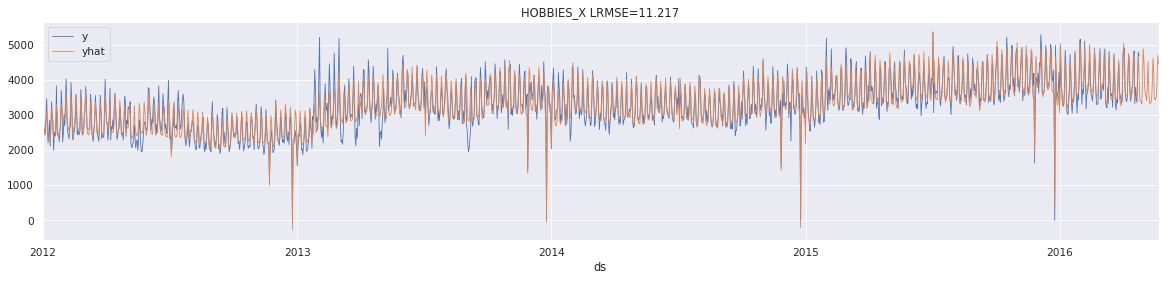

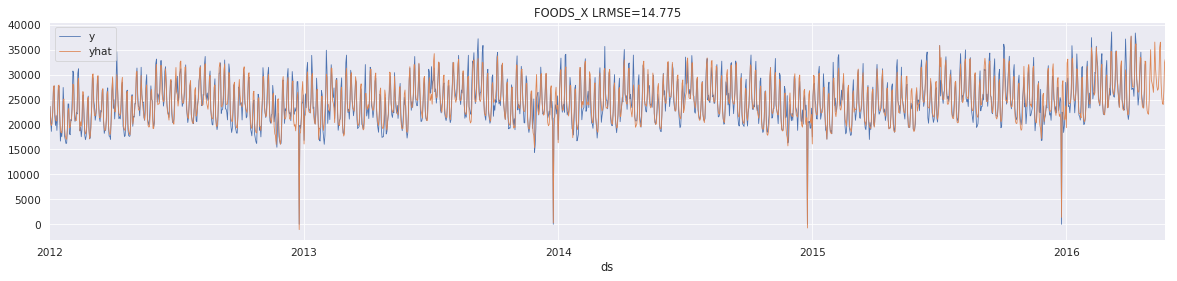

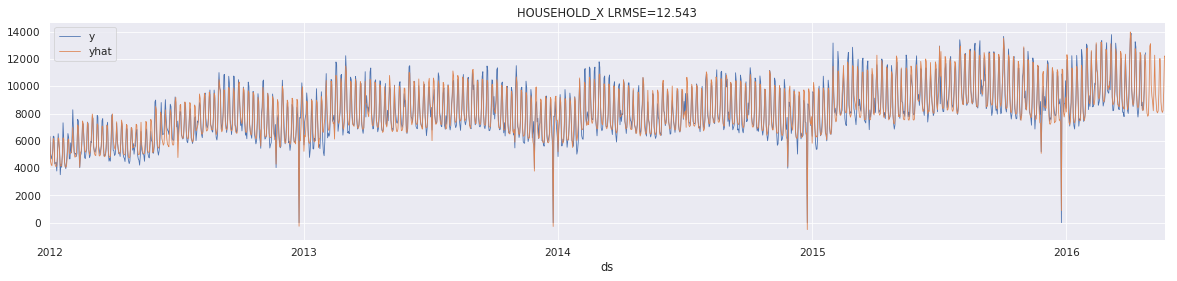

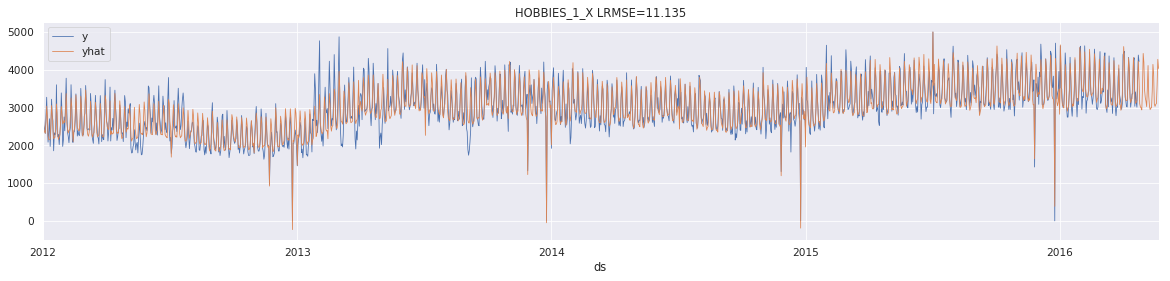

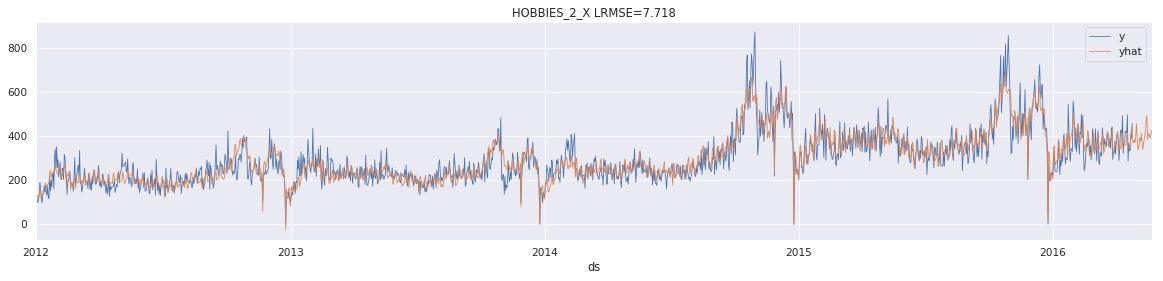

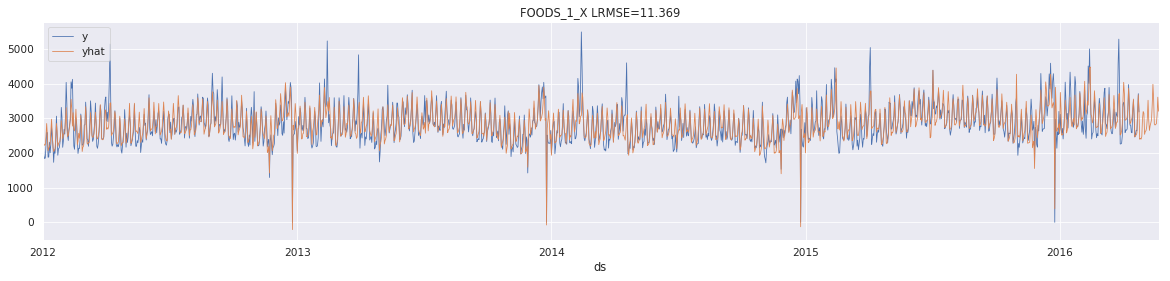

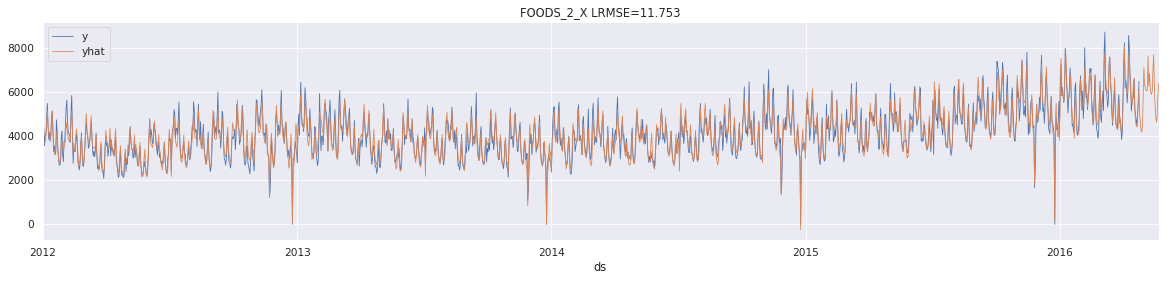

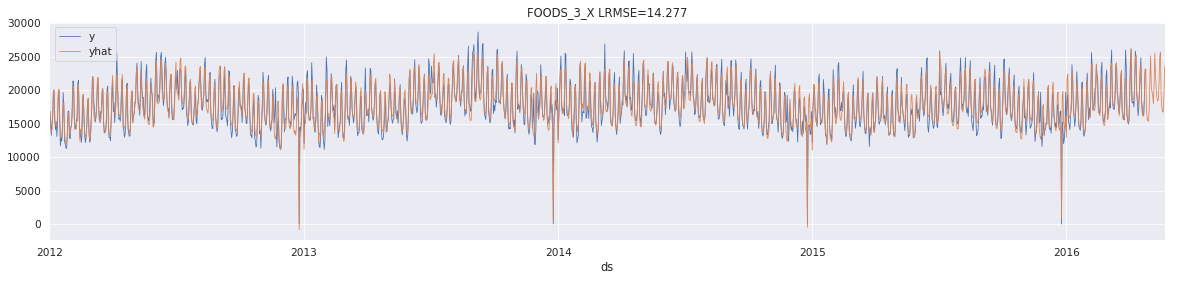

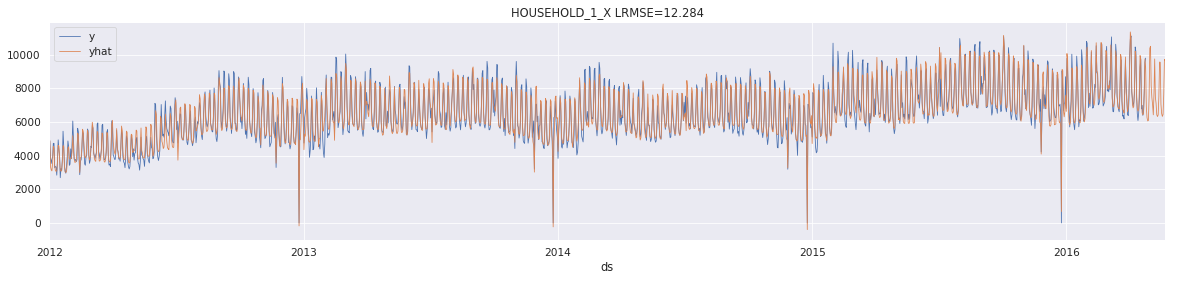

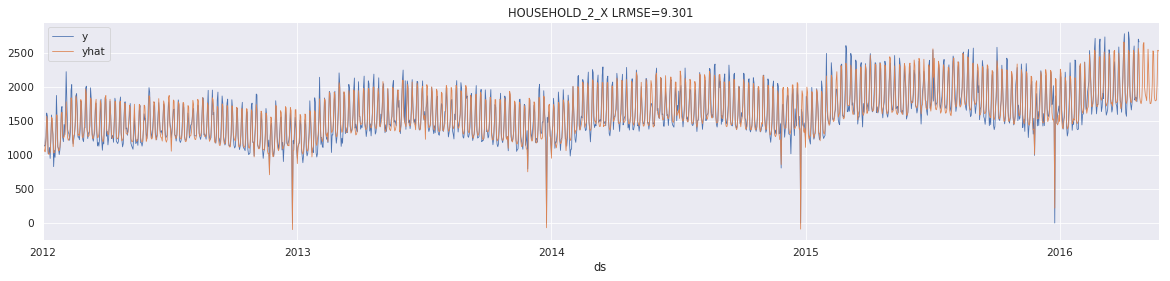

Average LRMSE=11.870


In [54]:
# Basic EDA and hyperparameters tuning
# model_columns = ['yhat']
# ret_columns = model_columns + ["ds", "y"]

# L1
train_indxs = ["Total_X"]
# L2
train_indxs = train_indxs + ["CA_X", "TX_X", "WI_X"] 
# L3
train_indxs = train_indxs + ['CA_1_X', 'CA_2_X', 'CA_3_X','CA_4_X', 'TX_1_X', 'TX_2_X', 
                             'TX_3_X', 'WI_1_X', 'WI_2_X', 'WI_3_X']
# L4
train_indxs = train_indxs + ['HOBBIES_X', 'FOODS_X', 'HOUSEHOLD_X']
# L5
train_indxs = train_indxs + ['HOBBIES_1_X', 'HOBBIES_2_X', 'FOODS_1_X', 'FOODS_2_X', 
                             'FOODS_3_X', 'HOUSEHOLD_1_X', 'HOUSEHOLD_2_X'] 

m_score = 0
for train_ind in train_indxs:
    (_, pred) = make_prediction(train_ind, model_columns = ['yhat'], ret_columns = ['yhat', 'ds', 'y']) # 'prices'
    fig, ax = plt.subplots(figsize=(DEFAULT_FIG_WIDTH, 4))
    d = pred.set_index("ds").plot(kind="line", y=["y", "yhat"], ax=ax, linestyle='-', linewidth=0.8) # 'prices'
    
    score = np.log1p(mean_squared_error(pred["y"][:-28], pred["yhat"][:-28]))
    m_score = m_score + (score / len(train_indxs))
    plt.title("%s LRMSE=%.3f" % (train_ind, score))
    plt.show()
    #break
print("Average LRMSE=%.3f" % m_score)

In [55]:
pred.head(2)

yhat         ds     y
d_338  1359.151855 2012-01-01   962
d_339  1466.394287 2012-01-02  1462

### 4.3 所有聚合时间序列预测

- 在这里预测是全天候，可以只预测要预测的天
- 多时间序列预测
- 规范化结果
- 保存模型

In [36]:
print('Predicting...', flush=True)
start_time = time.time()
#pool = Pool()

train_indxs = df_train.index #[0:10]

# Memory crash with multiple CPU on Kaggle
# res = pool.map(make_prediction, train_indxs)
# res = process_map(make_prediction, train_indxs, chunksize=1)
res = []
print('========================= train_indxs长度时间序列数量 =========================')
print(len(train_indxs))
print('========================= 根据不同的id聚合的日销量预测 =========================')
for train_indx in tqdm(train_indxs):
    r = make_prediction(train_indx)
    res.append(r)
    
#pool.close()
#pool.join()
end_time = time.time()
print('Exec speed=%.2f for every ts' %((end_time-start_time)/train_indxs.shape[0]))

Predicting...


  0%|          | 0/154 [00:00<?, ?it/s]

========================= train_indxs长度时间序列数量 =========================
154
========================= 根据不同的id聚合的日销量预测 =========================


100%|██████████| 154/154 [08:46<00:00,  3.42s/it]

Exec speed=3.42 for every ts


In [37]:
# Convert back to initial format
tmp = pd.DataFrame()
for result in tqdm(res):
    uid = result[0]
    ret = result[1].rename(uid)
    tmp = pd.concat([tmp, ret], axis=1)
fbp_pd = tmp.T
fbp_pd.index.name = "id"
fbp_pd.head()

100%|██████████| 154/154 [00:00<00:00, 499.40it/s]


d_338         d_339         d_340         d_341         d_342  \
id                                                                              
Total_X  28628.783203  33104.562500  26951.156250  26135.375000  26344.759766   
CA_X     13619.136719  15169.130859  12496.595703  11915.113281  11781.064453   
TX_X      9583.022461   9268.083008   8088.402832   7087.369141   7970.245605   
WI_X      5659.542969   8579.894531   7132.655762   6083.301270   6982.465332   
CA_1_X    3797.176514   3933.956055   3442.704102   3233.967285   3195.261963   

                d_343         d_344         d_345         d_346         d_347  \
id                                                                              
Total_X  29899.644531  36233.093750  36323.730469  28552.267578  26992.492188   
CA_X     13172.946289  16474.111328  16879.314453  13337.308594  12719.309570   
TX_X      8884.059570  11386.392578  10371.613281   8796.925781   7300.821289   
WI_X      7843.234375   7879.704102   8620.666992   7157.072754   6099.486328   
CA_1_X    3719.741211   4657.798828   4707.421387   3570.648438   3350.682617   

                d_348         d_349         d_350         d_351         d_352  \
id                                                                              
Total_X  26644.039062  26765.066406  30298.177734  36872.996094  36654.183594   
CA_X     11553.399414  11569.058594  12895.886719  15927.127930  16346.384766   
TX_X      8030.782715   8216.715820   9228.156250  10376.986328  11507.453125   
WI_X      7170.722168   7263.465332   7237.846680   9539.839844   9086.969727   
CA_1_X    2988.968262   2954.791748   3417.554932   4277.776855   4420.648926   

                d_353         d_354         d_355         d_356         d_357  \
id                                                                              
Total_X  29591.501953  25266.941406  24640.792969  24687.619141  27849.191406   
CA_X     13908.323242  11757.427734  11474.740234  11448.444336  12837.750000   
TX_X      8990.959961   7420.184082   7341.104004   7292.077148   7980.500000   
WI_X      6404.472656   5984.168457   5807.939453   5832.582520   6698.676270   
CA_1_X    3632.369385   2925.047852   2869.621582   2886.639893   3387.369141   

                d_358         d_359         d_360         d_361         d_362  \
id                                                                              
Total_X  34175.164062  34338.296875  26193.041016  24136.175781  23689.771484   
CA_X     16044.336914  16518.978516  12529.651367  11491.163086  11234.667969   
TX_X      9849.067383  10381.224609   7934.930664   7085.006348   7019.811523   
WI_X      7795.278809   7178.243164   5686.768555   5557.669922   5537.028320   
CA_1_X    4274.786133   4431.611816   3198.267334   2834.531982   2740.847900   

                d_363         d_364         d_365         d_366         d_367  \
id                                                                              
Total_X  23755.103516  26619.355469  32443.023438  32802.902344  27535.830078   
CA_X     11223.798828  12322.209961  15224.887695  15837.810547  12848.910156   
TX_X      7081.818359   7706.777344   9342.183594   9864.706055   8008.177734   
WI_X      5511.770508   6349.821289   7547.743164   7151.860840   6460.444824   
CA_1_X    2734.831543   3184.156006   4036.953125   4255.458008   3337.657471   

                d_368         d_369         d_370         d_371         d_372  \
id                                                                              
Total_X  27570.839844  28761.085938  29376.335938  32194.542969  38908.394531   
CA_X     11932.933594  12791.251953  12992.051758  14145.461914  17251.238281   
TX_X      7635.068848   8696.119141   8010.489746   9412.424805  10518.917969   
WI_X      6761.214844   7070.111816   8264.497070   9123.570312   9279.374023   
CA_1_X    3077.789062   3431.794922   3516.898438   3978.020996   4829.199707   

                d_373         d_374     

In [38]:
fbp_pd.to_pickle("model_fit.pkl.gz", compression="gzip")

In [39]:
yhat_df = fbp_pd.reset_index()
print(yhat_df.shape)
yhat_df.head()

(154, 1605)


id         d_338         d_339         d_340         d_341  \
0  Total_X  28628.783203  33104.562500  26951.156250  26135.375000   
1     CA_X  13619.136719  15169.130859  12496.595703  11915.113281   
2     TX_X   9583.022461   9268.083008   8088.402832   7087.369141   
3     WI_X   5659.542969   8579.894531   7132.655762   6083.301270   
4   CA_1_X   3797.176514   3933.956055   3442.704102   3233.967285   

          d_342         d_343         d_344         d_345         d_346  \
0  26344.759766  29899.644531  36233.093750  36323.730469  28552.267578   
1  11781.064453  13172.946289  16474.111328  16879.314453  13337.308594   
2   7970.245605   8884.059570  11386.392578  10371.613281   8796.925781   
3   6982.465332   7843.234375   7879.704102   8620.666992   7157.072754   
4   3195.261963   3719.741211   4657.798828   4707.421387   3570.648438   

          d_347         d_348         d_349         d_350         d_351  \
0  26992.492188  26644.039062  26765.066406  30298.177734  36872.996094   
1  12719.309570  11553.399414  11569.058594  12895.886719  15927.127930   
2   7300.821289   8030.782715   8216.715820   9228.156250  10376.986328   
3   6099.486328   7170.722168   7263.465332   7237.846680   9539.839844   
4   3350.682617   2988.968262   2954.791748   3417.554932   4277.776855   

          d_352         d_353         d_354         d_355         d_356  \
0  36654.183594  29591.501953  25266.941406  24640.792969  24687.619141   
1  16346.384766  13908.323242  11757.427734  11474.740234  11448.444336   
2  11507.453125   8990.959961   7420.184082   7341.104004   7292.077148   
3   9086.969727   6404.472656   5984.168457   5807.939453   5832.582520   
4   4420.648926   3632.369385   2925.047852   2869.621582   2886.639893   

          d_357         d_358         d_359         d_360         d_361  \
0  27849.191406  34175.164062  34338.296875  26193.041016  24136.175781   
1  12837.750000  16044.336914  16518.978516  12529.651367  11491.163086   
2   7980.500000   9849.067383  10381.224609   7934.930664   7085.006348   
3   6698.676270   7795.278809   7178.243164   5686.768555   5557.669922   
4   3387.369141   4274.786133   4431.611816   3198.267334   2834.531982   

          d_362         d_363         d_364         d_365         d_366  \
0  23689.771484  23755.103516  26619.355469  32443.023438  32802.902344   
1  11234.667969  11223.798828  12322.209961  15224.887695  15837.810547   
2   7019.811523   7081.818359   7706.777344   9342.183594   9864.706055   
3   5537.028320   5511.770508   6349.821289   7547.743164   7151.860840   
4   2740.847900   2734.831543   3184.156006   4036.953125   4255.458008   

          d_367         d_368         d_369         d_370         d_371  \
0  27535.830078  27570.839844  28761.085938  29376.335938  32194.542969   
1  12848.910156  11932.933594  12791.251953  12992.051758  14145.461914   
2   8008.177734   7635.068848   8696.119141   8010.489746   9412.424805   
3   6460.444824   6761.214844   7070.111816   8264.497070   9123.570312   
4   3337.657471   3077.789062   3431.794922   3516.898438   3978.020996   

          d_372         d_373         d_374         d_375         d_376  \
0  38908.394531  36335.242188  30125.205078  28279.255859  28481.203125   
1  17251.238281  15942.619141  13676.596680  12680.274414  12478.162109   
2  10518.917969  11934.045898   9322.787109   8661.589844   7865.478516   
3   9279.374023   8627.750977   7885.636719   6709.524414   8077.946777   
4   4829.199707   4317.115723   3723.338623   3338.554443   3269.458740   

          d_377         d_378         d_379         d_380         d_381  \
0  28517.101562  32454.177734  39391.980469  39723.609375  31553.611328   
1  12791.048828  14659.598633  17077.855469  17486.164062  13353.445312   
2   8714.496094   8867.981445  11628.878906  12416.092773  10068.647461   
3   7949.081543   8038.406738  10735.965820  10113.815430   7610.057129   
4   3386.774658   4112.727539   4753.121094   4809.5712

In [40]:
fbp_pd.head()

d_338         d_339         d_340         d_341         d_342  \
id                                                                              
Total_X  28628.783203  33104.562500  26951.156250  26135.375000  26344.759766   
CA_X     13619.136719  15169.130859  12496.595703  11915.113281  11781.064453   
TX_X      9583.022461   9268.083008   8088.402832   7087.369141   7970.245605   
WI_X      5659.542969   8579.894531   7132.655762   6083.301270   6982.465332   
CA_1_X    3797.176514   3933.956055   3442.704102   3233.967285   3195.261963   

                d_343         d_344         d_345         d_346         d_347  \
id                                                                              
Total_X  29899.644531  36233.093750  36323.730469  28552.267578  26992.492188   
CA_X     13172.946289  16474.111328  16879.314453  13337.308594  12719.309570   
TX_X      8884.059570  11386.392578  10371.613281   8796.925781   7300.821289   
WI_X      7843.234375   7879.704102   8620.666992   7157.072754   6099.486328   
CA_1_X    3719.741211   4657.798828   4707.421387   3570.648438   3350.682617   

                d_348         d_349         d_350         d_351         d_352  \
id                                                                              
Total_X  26644.039062  26765.066406  30298.177734  36872.996094  36654.183594   
CA_X     11553.399414  11569.058594  12895.886719  15927.127930  16346.384766   
TX_X      8030.782715   8216.715820   9228.156250  10376.986328  11507.453125   
WI_X      7170.722168   7263.465332   7237.846680   9539.839844   9086.969727   
CA_1_X    2988.968262   2954.791748   3417.554932   4277.776855   4420.648926   

                d_353         d_354         d_355         d_356         d_357  \
id                                                                              
Total_X  29591.501953  25266.941406  24640.792969  24687.619141  27849.191406   
CA_X     13908.323242  11757.427734  11474.740234  11448.444336  12837.750000   
TX_X      8990.959961   7420.184082   7341.104004   7292.077148   7980.500000   
WI_X      6404.472656   5984.168457   5807.939453   5832.582520   6698.676270   
CA_1_X    3632.369385   2925.047852   2869.621582   2886.639893   3387.369141   

                d_358         d_359         d_360         d_361         d_362  \
id                                                                              
Total_X  34175.164062  34338.296875  26193.041016  24136.175781  23689.771484   
CA_X     16044.336914  16518.978516  12529.651367  11491.163086  11234.667969   
TX_X      9849.067383  10381.224609   7934.930664   7085.006348   7019.811523   
WI_X      7795.278809   7178.243164   5686.768555   5557.669922   5537.028320   
CA_1_X    4274.786133   4431.611816   3198.267334   2834.531982   2740.847900   

                d_363         d_364         d_365         d_366         d_367  \
id                                                                              
Total_X  23755.103516  26619.355469  32443.023438  32802.902344  27535.830078   
CA_X     11223.798828  12322.209961  15224.887695  15837.810547  12848.910156   
TX_X      7081.818359   7706.777344   9342.183594   9864.706055   8008.177734   
WI_X      5511.770508   6349.821289   7547.743164   7151.860840   6460.444824   
CA_1_X    2734.831543   3184.156006   4036.953125   4255.458008   3337.657471   

                d_368         d_369         d_370         d_371         d_372  \
id                                                                              
Total_X  27570.839844  28761.085938  29376.335938  32194.542969  38908.394531   
CA_X     11932.933594  12791.251953  12992.051758  14145.461914  17251.238281   
TX_X      7635.068848   8696.119141   8010.489746   9412.424805  10518.917969   
WI_X      6761.214844   7070.111816   8264.497070   9123.570312   9279.374023   
CA_1_X    3077.789062   3431.794922   3516.898438   3978.020996   4829.199707   

                d_373         d_374     

# 5. 重新规划要预测的最细粒度的时间序列数据

In [41]:
df_sale = df_sale.reset_index()
df_sale.head()

d                id  level state_id store_id cat_id  dept_id      item_id  \
0  FOODS_1_001_CA_1     12       CA     CA_1  FOODS  FOODS_1  FOODS_1_001   
1  FOODS_1_001_CA_2     12       CA     CA_2  FOODS  FOODS_1  FOODS_1_001   
2  FOODS_1_001_CA_3     12       CA     CA_3  FOODS  FOODS_1  FOODS_1_001   
3  FOODS_1_001_CA_4     12       CA     CA_4  FOODS  FOODS_1  FOODS_1_001   
4  FOODS_1_002_CA_1     12       CA     CA_1  FOODS  FOODS_1  FOODS_1_002   

d  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  d_13  d_14  \
0  3.0  0.0  0.0  1.0  4.0  2.0  0.0  2.0  0.0   0.0   0.0   0.0   3.0   1.0   
1  2.0  0.0  0.0  0.0  1.0  0.0  8.0  0.0  4.0   1.0   2.0   1.0   1.0   3.0   
2  1.0  2.0  1.0  1.0  1.0  2.0  0.0  1.0  1.0   1.0   0.0   0.0   3.0   3.0   
3  0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   0.0   0.0   0.0   1.0   2.0   
4  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   0.0   1.0   1.0   0.0   2.0   

d  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  d_25  d_26  \
0   3.0   0.0   2.0   1.0   2.0   0.0   2.0   1.0   2.0   0.0   2.0   2.0   
1   4.0   1.0   2.0   2.0   2.0   0.0   1.0   1.0   1.0   1.0   2.0   3.0   
2   2.0   7.0   1.0   2.0   4.0   0.0   1.0   1.0   3.0   2.0   0.0   0.0   
3   1.0   0.0   1.0   0.0   0.0   1.0   0.0   2.0   0.0   1.0   0.0   1.0   
4   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

d  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  d_37  d_38  \
0   2.0   4.0   2.0   2.0   0.0   2.0   1.0   7.0   1.0   2.0   3.0   0.0   
1  16.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   3.0   1.0   
2   0.0   0.0   6.0   6.0   1.0   1.0   0.0   0.0   4.0   3.0   6.0   5.0   
3   1.0   0.0   1.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   1.0   2.0   
4   0.0   0.0   1.0   0.0   0.0   1.0   1.0   0.0   1.0   1.0   3.0   0.0   

d  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  d_50  \
0   1.0   2.0   3.0   0.0   1.0   5.0   0.0   0.0   1.0   0.0   0.0   1.0   
1   0.0   0.0   0.0   1.0   2.0   1.0   1.0   0.0   0.0   3.0   3.0   4.0   
2   1.0   0.0   3.0   1.0   1.0   1.0   0.0   1.0   3.0   0.0   0.0   1.0   
3   2.0   2.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   4.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   1.0   

d  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  d_62  \
0   1.0   1.0   1.0   1.0   0.0   1.0   2.0   2.0   0.0   1.0   0.0   0.0   
1   0.0   0.0   3.0   1.0   2.0   0.0   1.0   2.0   1.0   0.0   2.0   0.0   
2   1.0   4.0   1.0   0.0   0.0   1.0   1.0   1.0   2.0   3.0   0.0   0.0   
3   1.0   2.0   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   2.0   
4   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   2.0   0.0   0.0   0.0   

d  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  d_73  d_74  \
0   0.0   0.0   0.0   4.0   0.0   1.0   0.0   1.0   0.0   2.0   2.0   1.0   
1   1.0   2.0   1.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
2   1.0   3.0   0.0   4.0   2.0   1.0   5.0   4.0   1.0   3.0   0.0   4.0   
3   2.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   
4   0.0   0.0   1.0   0.0   0.0   2.0   0.0   0.0   1.0   0.0   0.0   0.0   

d  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  d_85  d_86  \
0   1.0   0.0   2.0   1.0   2.0   0.0   2.0   0.0   0.0   0.0   1.0   0.0   
1   1.0   1.0   1.0   1.0   1.0   0.0   0.0   2.0   0.0   2.0   3.0   0.0   
2   0.0   1.0   1.0   8.0   0.0   2.0   1.0   2.0   0.0   5.0   9.0   1.0   
3   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   2.0   1.0   
4   0.0   0.0   4.0   0.0   0.0   0.0   0.0   3.0   0.0   1.0   0.0   1.0   

d  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  d_97  d_98  \
0   0.0   0.0   0.0   0.0   0.0   3.0   2.0   7.0   1.0   0.0   0.0   9.0   
1   7.0   0.0   0.0   1.0   2.0   3.0   0.0   0.0   4.0   2.0   1.0   0.0   
2   0.0   1.0   0.0   2.0   1.0   1.0   2.0   1

In [42]:
yhat_df.head()

id         d_338         d_339         d_340         d_341  \
0  Total_X  28628.783203  33104.562500  26951.156250  26135.375000   
1     CA_X  13619.136719  15169.130859  12496.595703  11915.113281   
2     TX_X   9583.022461   9268.083008   8088.402832   7087.369141   
3     WI_X   5659.542969   8579.894531   7132.655762   6083.301270   
4   CA_1_X   3797.176514   3933.956055   3442.704102   3233.967285   

          d_342         d_343         d_344         d_345         d_346  \
0  26344.759766  29899.644531  36233.093750  36323.730469  28552.267578   
1  11781.064453  13172.946289  16474.111328  16879.314453  13337.308594   
2   7970.245605   8884.059570  11386.392578  10371.613281   8796.925781   
3   6982.465332   7843.234375   7879.704102   8620.666992   7157.072754   
4   3195.261963   3719.741211   4657.798828   4707.421387   3570.648438   

          d_347         d_348         d_349         d_350         d_351  \
0  26992.492188  26644.039062  26765.066406  30298.177734  36872.996094   
1  12719.309570  11553.399414  11569.058594  12895.886719  15927.127930   
2   7300.821289   8030.782715   8216.715820   9228.156250  10376.986328   
3   6099.486328   7170.722168   7263.465332   7237.846680   9539.839844   
4   3350.682617   2988.968262   2954.791748   3417.554932   4277.776855   

          d_352         d_353         d_354         d_355         d_356  \
0  36654.183594  29591.501953  25266.941406  24640.792969  24687.619141   
1  16346.384766  13908.323242  11757.427734  11474.740234  11448.444336   
2  11507.453125   8990.959961   7420.184082   7341.104004   7292.077148   
3   9086.969727   6404.472656   5984.168457   5807.939453   5832.582520   
4   4420.648926   3632.369385   2925.047852   2869.621582   2886.639893   

          d_357         d_358         d_359         d_360         d_361  \
0  27849.191406  34175.164062  34338.296875  26193.041016  24136.175781   
1  12837.750000  16044.336914  16518.978516  12529.651367  11491.163086   
2   7980.500000   9849.067383  10381.224609   7934.930664   7085.006348   
3   6698.676270   7795.278809   7178.243164   5686.768555   5557.669922   
4   3387.369141   4274.786133   4431.611816   3198.267334   2834.531982   

          d_362         d_363         d_364         d_365         d_366  \
0  23689.771484  23755.103516  26619.355469  32443.023438  32802.902344   
1  11234.667969  11223.798828  12322.209961  15224.887695  15837.810547   
2   7019.811523   7081.818359   7706.777344   9342.183594   9864.706055   
3   5537.028320   5511.770508   6349.821289   7547.743164   7151.860840   
4   2740.847900   2734.831543   3184.156006   4036.953125   4255.458008   

          d_367         d_368         d_369         d_370         d_371  \
0  27535.830078  27570.839844  28761.085938  29376.335938  32194.542969   
1  12848.910156  11932.933594  12791.251953  12992.051758  14145.461914   
2   8008.177734   7635.068848   8696.119141   8010.489746   9412.424805   
3   6460.444824   6761.214844   7070.111816   8264.497070   9123.570312   
4   3337.657471   3077.789062   3431.794922   3516.898438   3978.020996   

          d_372         d_373         d_374         d_375         d_376  \
0  38908.394531  36335.242188  30125.205078  28279.255859  28481.203125   
1  17251.238281  15942.619141  13676.596680  12680.274414  12478.162109   
2  10518.917969  11934.045898   9322.787109   8661.589844   7865.478516   
3   9279.374023   8627.750977   7885.636719   6709.524414   8077.946777   
4   4829.199707   4317.115723   3723.338623   3338.554443   3269.458740   

          d_377         d_378         d_379         d_380         d_381  \
0  28517.101562  32454.177734  39391.980469  39723.609375  31553.611328   
1  12791.048828  14659.598633  17077.855469  17486.164062  13353.445312   
2   8714.496094   8867.981445  11628.878906  12416.092773  10068.647461   
3   7949.081543   8038.406738  10735.965820  10113.815430   7610.057129   
4   3386.774658   4112.727539   4753.121094   4809.5712

In [43]:
yhat_df.shape

(154, 1605)

In [44]:
print(df_train.shape)
df_train.head()

(154, 1582)


d       item_id dept_id cat_id store_id state_id  level    d_338    d_339  \
id                                                                          
Total_X     NaN     NaN    NaN      NaN      NaN      1  21807.0  33053.0   
CA_X        NaN     NaN    NaN      NaN       CA      2  10218.0  15152.0   
TX_X        NaN     NaN    NaN      NaN       TX      2   7224.0   9307.0   
WI_X        NaN     NaN    NaN      NaN       WI      2   4365.0   8594.0   
CA_1_X      NaN     NaN    NaN     CA_1       CA      3   2648.0   3931.0   

d          d_340    d_341    d_342    d_343    d_344    d_345    d_346  \
id                                                                       
Total_X  28751.0  25821.0  28499.0  30405.0  37143.0  36722.0  28206.0   
CA_X     12740.0  11512.0  12283.0  12809.0  16634.0  17261.0  13418.0   
TX_X      8345.0   7530.0   8558.0   9197.0  11191.0  10981.0   7173.0   
WI_X      7666.0   6779.0   7658.0   8399.0   9318.0   8480.0   7615.0   
CA_1_X    3496.0   3284.0   3444.0   3854.0   4670.0   4585.0   3637.0   

d          d_347    d_348    d_349    d_350    d_351    d_352    d_353  \
id                                                                       
Total_X  26640.0  29044.0  24715.0  29463.0  36815.0  36459.0  30548.0   
CA_X     12192.0  11470.0  10549.0  13098.0  15748.0  15729.0  14013.0   
TX_X      7940.0   8551.0   7901.0   9508.0  10482.0  11336.0   9018.0   
WI_X      6508.0   9023.0   6265.0   6857.0  10585.0   9394.0   7517.0   
CA_1_X    3217.0   2994.0   2655.0   3550.0   4271.0   4111.0   3670.0   

d          d_354    d_355    d_356    d_357    d_358    d_359    d_360  \
id                                                                       
Total_X  22187.0  25348.0  24034.0  27204.0  38578.0  32587.0  24702.0   
CA_X     10525.0  11172.0  10689.0  12202.0  18418.0  14539.0  11365.0   
TX_X      6925.0   7249.0   7069.0   8441.0  10606.0  10434.0   7619.0   
WI_X      4737.0   6927.0   6276.0   6561.0   9554.0   7614.0   5718.0   
CA_1_X    2824.0   2729.0   2782.0   3153.0   5107.0   3965.0   2678.0   

d          d_361    d_362    d_363    d_364    d_365    d_366    d_367  \
id                                                                       
Total_X  23549.0  22408.0  23237.0  27199.0  34362.0  33577.0  25188.0   
CA_X     11109.0  10622.0  10471.0  12353.0  15406.0  16101.0  11745.0   
TX_X      6593.0   6163.0   6757.0   7920.0  10189.0  10428.0   7645.0   
WI_X      5847.0   5623.0   6009.0   6926.0   8767.0   7048.0   5798.0   
CA_1_X    2571.0   2460.0   2680.0   3444.0   4241.0   4147.0   2889.0   

d          d_368    d_369    d_370    d_371    d_372    d_373    d_374  \
id                                                                       
Total_X  25124.0  29851.0  28615.0  35104.0  43029.0  40075.0  30681.0   
CA_X     11836.0  12931.0  12804.0  15263.0  20129.0  17149.0  13798.0   
TX_X      7136.0   9481.0   7708.0   9950.0  12224.0  13255.0   9108.0   
WI_X      6152.0   7439.0   8103.0   9891.0  10676.0   9671.0   7775.0   
CA_1_X    2892.0   3205.0   3409.0   4269.0   5786.0   4783.0   3638.0   

d          d_375    d_376    d_377    d_378    d_379    d_380    d_381  \
id                                                                       
Total_X  28108.0  28579.0  29927.0  29863.0  41757.0  41904.0  31675.0   
CA_X     12785.0  12568.0  12783.0  14425.0  19661.0  18559.0  13954.0   
TX_X      8889.0   8174.0   8329.0   8128.0  11675.0  12585.0  10394.0   
WI_X      6434.0   7837.0   8815.0   7310.0  10421.0  10760.0   7327.0   
CA_1_X    3159.0   3041.0   3034.0   3516.0   5463.0   5230.0   3674.0   

d          d_382    d_383    d_384    d_385    d_386    d_387    d_388  \
id                                                                       
Total_X  25100.0  26878.0  25195.0  27604.0  36622.0  36338.0  30218.0   
CA_X     10417.0  10994.0  10984.0  12922.0  16872.0  16159.0  15012.0   
TX_X      8084.0   8240.0   7754.0   7653.0  10383

In [45]:
# Merge back to get levels info
yhat_df = pd.merge(yhat_df, df_train.reset_index()[['id', 'level', 'state_id', 'store_id',   'cat_id',  'dept_id',  'item_id']], on=["id"], how="left")
print(yhat_df.shape)
yhat_df.head()

(154, 1611)


id         d_338         d_339         d_340         d_341  \
0  Total_X  28628.783203  33104.562500  26951.156250  26135.375000   
1     CA_X  13619.136719  15169.130859  12496.595703  11915.113281   
2     TX_X   9583.022461   9268.083008   8088.402832   7087.369141   
3     WI_X   5659.542969   8579.894531   7132.655762   6083.301270   
4   CA_1_X   3797.176514   3933.956055   3442.704102   3233.967285   

          d_342         d_343         d_344         d_345         d_346  \
0  26344.759766  29899.644531  36233.093750  36323.730469  28552.267578   
1  11781.064453  13172.946289  16474.111328  16879.314453  13337.308594   
2   7970.245605   8884.059570  11386.392578  10371.613281   8796.925781   
3   6982.465332   7843.234375   7879.704102   8620.666992   7157.072754   
4   3195.261963   3719.741211   4657.798828   4707.421387   3570.648438   

          d_347         d_348         d_349         d_350         d_351  \
0  26992.492188  26644.039062  26765.066406  30298.177734  36872.996094   
1  12719.309570  11553.399414  11569.058594  12895.886719  15927.127930   
2   7300.821289   8030.782715   8216.715820   9228.156250  10376.986328   
3   6099.486328   7170.722168   7263.465332   7237.846680   9539.839844   
4   3350.682617   2988.968262   2954.791748   3417.554932   4277.776855   

          d_352         d_353         d_354         d_355         d_356  \
0  36654.183594  29591.501953  25266.941406  24640.792969  24687.619141   
1  16346.384766  13908.323242  11757.427734  11474.740234  11448.444336   
2  11507.453125   8990.959961   7420.184082   7341.104004   7292.077148   
3   9086.969727   6404.472656   5984.168457   5807.939453   5832.582520   
4   4420.648926   3632.369385   2925.047852   2869.621582   2886.639893   

          d_357         d_358         d_359         d_360         d_361  \
0  27849.191406  34175.164062  34338.296875  26193.041016  24136.175781   
1  12837.750000  16044.336914  16518.978516  12529.651367  11491.163086   
2   7980.500000   9849.067383  10381.224609   7934.930664   7085.006348   
3   6698.676270   7795.278809   7178.243164   5686.768555   5557.669922   
4   3387.369141   4274.786133   4431.611816   3198.267334   2834.531982   

          d_362         d_363         d_364         d_365         d_366  \
0  23689.771484  23755.103516  26619.355469  32443.023438  32802.902344   
1  11234.667969  11223.798828  12322.209961  15224.887695  15837.810547   
2   7019.811523   7081.818359   7706.777344   9342.183594   9864.706055   
3   5537.028320   5511.770508   6349.821289   7547.743164   7151.860840   
4   2740.847900   2734.831543   3184.156006   4036.953125   4255.458008   

          d_367         d_368         d_369         d_370         d_371  \
0  27535.830078  27570.839844  28761.085938  29376.335938  32194.542969   
1  12848.910156  11932.933594  12791.251953  12992.051758  14145.461914   
2   8008.177734   7635.068848   8696.119141   8010.489746   9412.424805   
3   6460.444824   6761.214844   7070.111816   8264.497070   9123.570312   
4   3337.657471   3077.789062   3431.794922   3516.898438   3978.020996   

          d_372         d_373         d_374         d_375         d_376  \
0  38908.394531  36335.242188  30125.205078  28279.255859  28481.203125   
1  17251.238281  15942.619141  13676.596680  12680.274414  12478.162109   
2  10518.917969  11934.045898   9322.787109   8661.589844   7865.478516   
3   9279.374023   8627.750977   7885.636719   6709.524414   8077.946777   
4   4829.199707   4317.115723   3723.338623   3338.554443   3269.458740   

          d_377         d_378         d_379         d_380         d_381  \
0  28517.101562  32454.177734  39391.980469  39723.609375  31553.611328   
1  12791.048828  14659.598633  17077.855469  17486.164062  13353.445312   
2   8714.496094   8867.981445  11628.878906  12416.092773  10068.647461   
3   7949.081543   8038.406738  10735.965820  10113.815430   7610.057129   
4   3386.774658   4112.727539   4753.121094   4809.5712

In [46]:
print(yhat_df["level"].unique())

[1 2 3 4 5 6 7 8 9]


In [47]:
df_sale.tail()

d                        id  level state_id store_id     cat_id      dept_id  \
30485  HOUSEHOLD_2_515_WI_2     12       WI     WI_2  HOUSEHOLD  HOUSEHOLD_2   
30486  HOUSEHOLD_2_515_WI_3     12       WI     WI_3  HOUSEHOLD  HOUSEHOLD_2   
30487  HOUSEHOLD_2_516_WI_1     12       WI     WI_1  HOUSEHOLD  HOUSEHOLD_2   
30488  HOUSEHOLD_2_516_WI_2     12       WI     WI_2  HOUSEHOLD  HOUSEHOLD_2   
30489  HOUSEHOLD_2_516_WI_3     12       WI     WI_3  HOUSEHOLD  HOUSEHOLD_2   

d              item_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
30485  HOUSEHOLD_2_515  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
30486  HOUSEHOLD_2_515  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
30487  HOUSEHOLD_2_516  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   0.0   
30488  HOUSEHOLD_2_516  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   
30489  HOUSEHOLD_2_516  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   0.0   

d      d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30486   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30487   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   
30488   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30489   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   

d      d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30486   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30487   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   
30488   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30489   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

d      d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30486   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30487   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   
30488   0.0   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
30489   0.0   1.0   0.0   1.0   0.0   0.0   3.0   1.0   0.0   0.0   0.0   0.0   

d      d_47  d_48  d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30486   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30487   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30488   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30489   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

d      d_59  d_60  d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30486   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30487   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
30488   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
30489   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

d      d_71  d_72  d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30486   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30487   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   
30488   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30489   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   

d      d_83  d_84  d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  \
30485   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

# 6. 小部分序列细粒度扩展计算结果

In [48]:
level_coef_dict = {
    12: ["id"], # L12 x30490
    10: ["item_id"], # L10 x3049
    5: ["dept_id"], # L5 x7
    4: ["cat_id"], # L4 x3
    3: ["store_id"], # L3 x10
    2: ["state_id"],  # L2 x3
    1: ["all"],  # L1 x1
    11: ["state_id", "item_id"], # L11 x9167
    7: ["state_id", "dept_id"],  # L7 x21
    9: ["store_id","dept_id"],  # L9 x70
    6: ["state_id", "cat_id"], # L6 x 9
    8: ["store_id","cat_id"], # L8 x30
}

### 6.1 结果计算函数

In [49]:
# Top-Down prediction
def predict_topdown(df, df_level12, items):
    df_level_forecast = pd.DataFrame()
    for idx, row in df.iterrows():
        item1 = items[0]
        if item1 is not "all":
            item1_id = row[item1]
#             print('item1:', item1)
#             print('item1_id:', item1_id)
        if len(items) == 2:
            item2 = items[1]
            item2_id = row[items[1]]

        ## 找到聚合序列中的每一个对应的id
        if item1 is not "all":
            # Find all level 12 items for the dept_id, store_id pair
            if len(items) == 2:
                df_item = df_level12.loc[(df_level12[item1] == item1_id) & (df_level12[item2] == item2_id)][['id']]
            else:
                df_item = df_level12.loc[df_level12[item1] == item1_id][['id']]
                
        else:
            df_item = df_level12[['id']]
        #print(df_item.shape)
        #display(df_item.head())

        # Sum sales from last 28 days in level 12 training
        # df_item['val']为item1_id最近28天的销量和
        if item1 is not "all":
            if len(items) == 2:
                df_item['val'] = df_level12[(df_level12[item1] == item1_id) & (df_level12[item2] == item2_id)].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
            else:
                df_item['val'] = df_level12[df_level12[item1] == item1_id].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
        else:
            df_item['val'] = df_level12.iloc[:, np.r_[0,-28:0]].sum(axis = 1)
        #display(df_item.head())

        # Back to per id prediction
        for i in range(1,29):
            col = "d_%d" % (1913 + i)
            p_col = "F%d" % i
            df_item[p_col] = (df_item['val'] * float(row[col]) / df_item['val'].sum())
#             print(df_item[p_col].head())
#             print(df_item[p_col].shape)
        #display(df_item.head())

        df_level_forecast = pd.concat([df_level_forecast, df_item])
    return df_level_forecast.drop(columns=["val"])

In [50]:
level_coef_dict

{12: ['id'],
 10: ['item_id'],
 5: ['dept_id'],
 4: ['cat_id'],
 3: ['store_id'],
 2: ['state_id'],
 1: ['all'],
 11: ['state_id', 'item_id'],
 7: ['state_id', 'dept_id'],
 9: ['store_id', 'dept_id'],
 6: ['state_id', 'cat_id'],
 8: ['store_id', 'cat_id']}

### 6.2 预测一部分时间序列看看结果

#### 说明

- yhat_df：为1-9个聚合等级下，用prophet得到的预测值+已知聚合xiaol数据。等级level字段是快速定位的关键（shape为【154, 1611】）。
- prediction：为level等于具体取值时的yhat_df数据。销量聚合数据的天数【d_338——d_1941】（后面28天是prophet根据历史预测得到）。
- df_sale：为原始销量数据，也是最细粒度的非聚合数据。

#### 预测的思路

- 因为最细粒度id的销量周期性不明显，且0销量取值太多，预测起来误差太大。
- 分解的思想是关键。
- 又因为粗粒度的聚合销量数据周期性明显，预测准确性高。
- 对于真实销量：计算某一类目下，各个分量最细粒度ID最近28天销量和占比R。
- 对于预测销量：需要预测各个聚合销量天级别S。
- 未来一天细粒度销量（某个类目下的一个商品id1） = R_id1 * S 



In [52]:
print('========================================== predictions ======================================')
print('预测表的列名..............')
print(yhat_df.columns)
for key, value in level_coef_dict.items():
    if (key <= MAX_LEVEL) and (key >= 1):
        predictions = yhat_df[yhat_df["level"] == key]
        # 重要！！！
        df_levelx_forecast = predict_topdown(predictions, df_sale, value)
        print("Top-Down prediction for level =【%s】,detail id =【%s】, items =【%s】 into %s" % (key, 
                                                                          value, 
                                                                          predictions.shape[0], 
                                                                          df_levelx_forecast.shape[0]))
        df_levelx_forecast.to_pickle(MODELS_DIR + "/level_%d.pkl.gz" % key, 
                                     compression="gzip")
        # display(df_levelx_forecast.head())
        print(df_levelx_forecast.shape)
df_levelx_forecast.head()

========================================== predictions ======================================
预测表的列名..............
Index(['id', 'd_338', 'd_339', 'd_340', 'd_341', 'd_342', 'd_343', 'd_344',
       'd_345', 'd_346',
       ...
       'd_1938', 'd_1939', 'd_1940', 'd_1941', 'level', 'state_id', 'store_id',
       'cat_id', 'dept_id', 'item_id'],
      dtype='object', length=1611)
Top-Down prediction for level =【5】,detail id =【['dept_id']】, items =【7】 into 30490
(30490, 29)
Top-Down prediction for level =【4】,detail id =【['cat_id']】, items =【3】 into 30490
(30490, 29)
Top-Down prediction for level =【3】,detail id =【['store_id']】, items =【10】 into 30490
(30490, 29)
Top-Down prediction for level =【2】,detail id =【['state_id']】, items =【3】 into 30490
(30490, 29)


/opt/conda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Top-Down prediction for level =【1】,detail id =【['all']】, items =【1】 into 30490
(30490, 29)
Top-Down prediction for level =【7】,detail id =【['state_id', 'dept_id']】, items =【21】 into 30490
(30490, 29)
Top-Down prediction for level =【9】,detail id =【['store_id', 'dept_id']】, items =【70】 into 30490
(30490, 29)
Top-Down prediction for level =【6】,detail id =【['state_id', 'cat_id']】, items =【9】 into 30490
(30490, 29)
Top-Down prediction for level =【8】,detail id =【['store_id', 'cat_id']】, items =【30】 into 30490
(30490, 29)


d                 id        F1        F2        F3        F4        F5  \
0   FOODS_1_001_CA_1  1.050698  0.940785  0.878987  0.925223  1.136064   
4   FOODS_1_002_CA_1  0.382072  0.342104  0.319632  0.336445  0.413114   
8   FOODS_1_003_CA_1  0.700465  0.627190  0.585991  0.616815  0.757376   
12  FOODS_1_004_CA_1  0.000000  0.000000  0.000000  0.000000  0.000000   
16  FOODS_1_005_CA_1  1.082537  0.969293  0.905623  0.953260  1.170491   

d         F6        F7        F8        F9       F10       F11       F12  \
0   1.466935  1.703499  1.276676  1.171124  1.129501  0.988901  1.293892   
4   0.533431  0.619454  0.464246  0.425863  0.410728  0.359600  0.470506   
8   0.977957  1.135666  0.851117  0.780749  0.753001  0.659267  0.862594   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  1.511388  1.755120  1.315363  1.206612  1.163728  1.018868  1.333100   

d        F13       F14       F15       F16       F17       F18       F19  \
0   1.621422  1.403054  1.264438  1.151234  1.060480  1.059198  1.215895   
4   0.589608  0.510201  0.459796  0.418631  0.385629  0.385163  0.442144   
8   1.080948  0.935369  0.842959  0.767490  0.706987  0.706132  0.810597   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  1.670556  1.445571  1.302755  1.186120  1.092616  1.091294  1.252741   

d        F20       F21       F22       F23       F24       F25       F26  \
0   1.509826  1.590587  1.143320  1.013105  0.995392  1.011581  1.184087   
4   0.549028  0.578395  0.415753  0.368402  0.361961  0.367848  0.430577   
8   1.006551  1.060391  0.762213  0.675403  0.663594  0.674387  0.789391   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  1.555578  1.638786  1.177966  1.043805  1.025555  1.042235  1.219968   

d        F27       F28  
0   1.478189  1.569705  
4   0.537523  0.570802  
8   0.985460  1.046470  
12  0.000000  0.000000  
16  1.522983  1.617271

### 6.3 可视化结果查看

- id = FOODS_1_001_CA_1

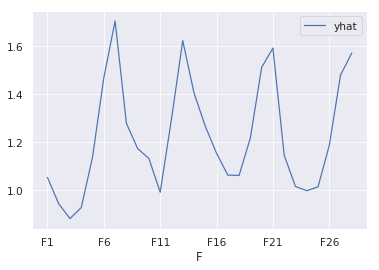

In [53]:
tmp_pd1 = df_levelx_forecast[df_levelx_forecast["id"].isin(["FOODS_1_001_CA_1"])]
tmp_pd1 = pd.melt(frame = tmp_pd1, 
                  id_vars = ['id'],
                  var_name = "F",
                  value_vars = [c for c in tmp_pd1.columns if "F" in c],
                  value_name = "yhat")
d = tmp_pd1.plot(kind="line", x="F", y="yhat")
plt.show()

# 7. 全量计算并规范化输出并保存

In [56]:
SAMPLE_SUBMISSION = TRAIN_DATA_HOME + "sample_submission.csv"
sub_ids = pd.read_csv(SAMPLE_SUBMISSION)[['id']]
sub_ids = sub_ids[sub_ids.id.str.endswith("validation")]

In [57]:
for key, value in tqdm(level_coef_dict.items()):
    if (key <= MAX_LEVEL) and (key >= 1):
        predictions = yhat_df[yhat_df["level"] == key]
        df_levelx_forecast = predict_topdown(predictions, df_sale, value)
        print("Top-Down prediction for level %s, %s, items=%s into %s" % (key, value, predictions.shape[0], df_levelx_forecast.shape[0]))
        df_levelx_forecast["id"] = df_levelx_forecast["id"].astype(str) + "_validation"
        part1 = pd.merge(sub_ids, df_levelx_forecast, on="id", how="left")
        part2 = part1.copy()
        part2["id"] = part2["id"].str.replace("validation$", "evaluation")
        sub = pd.concat([part1, part2])
        MODE_LEVEL_PATH = MODELS_DIR + "/level_%d" % key
        if not os.path.exists(MODE_LEVEL_PATH):
            os.makedirs(MODE_LEVEL_PATH)
        sub.to_csv(MODE_LEVEL_PATH + "/submission.csv.gz", compression="gzip", index=False)

  0%|          | 0/12 [00:00<?, ?it/s]

Top-Down prediction for level 5, ['dept_id'], items=7 into 30490


 25%|██▌       | 3/12 [00:06<00:18,  2.02s/it]

Top-Down prediction for level 4, ['cat_id'], items=3 into 30490


 33%|███▎      | 4/12 [00:11<00:25,  3.18s/it]

Top-Down prediction for level 3, ['store_id'], items=10 into 30490


 42%|████▏     | 5/12 [00:18<00:29,  4.15s/it]

Top-Down prediction for level 2, ['state_id'], items=3 into 30490


 50%|█████     | 6/12 [00:24<00:27,  4.66s/it]/opt/conda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Top-Down prediction for level 1, ['all'], items=1 into 30490


 58%|█████▊    | 7/12 [00:29<00:24,  4.81s/it]

Top-Down prediction for level 7, ['state_id', 'dept_id'], items=21 into 30490


 75%|███████▌  | 9/12 [00:36<00:13,  4.37s/it]

Top-Down prediction for level 9, ['store_id', 'dept_id'], items=70 into 30490


 83%|████████▎ | 10/12 [00:45<00:11,  5.86s/it]

Top-Down prediction for level 6, ['state_id', 'cat_id'], items=9 into 30490


 92%|█████████▏| 11/12 [00:51<00:05,  5.93s/it]

Top-Down prediction for level 8, ['store_id', 'cat_id'], items=30 into 30490


100%|██████████| 12/12 [00:58<00:00,  4.90s/it]


In [58]:
print(sub.shape)
sub.head()

(60980, 29)


id        F1        F2        F3        F4  \
0  HOBBIES_1_001_CA_1_validation  0.826463  0.803030  0.792612  0.775241   
1  HOBBIES_1_002_CA_1_validation  0.061219  0.059484  0.058712  0.057425   
2  HOBBIES_1_003_CA_1_validation  0.489756  0.475870  0.469696  0.459402   
3  HOBBIES_1_004_CA_1_validation  1.561097  1.516834  1.497157  1.464344   
4  HOBBIES_1_005_CA_1_validation  1.163170  1.130190  1.115529  1.091080   

         F5        F6        F7        F8        F9       F10       F11  \
0  0.934637  1.207560  1.201472  0.989418  0.918182  0.856646  0.839275   
1  0.069232  0.089449  0.088998  0.073290  0.068013  0.063455  0.062169   
2  0.553859  0.715591  0.711983  0.586322  0.544108  0.507642  0.497348   
3  1.765426  2.280947  2.269447  1.868900  1.734344  1.618109  1.585297   
4  1.315415  1.699530  1.690960  1.392514  1.292256  1.205650  1.181202   

        F12       F13       F14       F15       F16       F17       F18  \
0  0.969051  1.098404  0.855296  0.804935  0.798508  0.762045  0.788135   
1  0.071782  0.081363  0.063355  0.059625  0.059149  0.056448  0.058380   
2  0.574252  0.650906  0.506842  0.476999  0.473190  0.451582  0.467043   
3  1.830429  2.074764  1.615559  1.520433  1.508293  1.439419  1.488700   
4  1.363849  1.545903  1.203750  1.132872  1.123826  1.072508  1.109228   

        F19       F20       F21       F22       F23       F24       F25  \
0  0.914731  1.117171  1.062374  0.887575  0.846996  0.861974  0.889401   
1  0.067758  0.082753  0.078694  0.065746  0.062740  0.063850  0.065882   
2  0.542063  0.662027  0.629555  0.525971  0.501923  0.510799  0.527052   
3  1.727825  2.110212  2.006706  1.676531  1.599881  1.628172  1.679980   
4  1.287399  1.572315  1.495193  1.249180  1.192068  1.213148  1.251750   

        F26       F27       F28  
0  1.004950  1.211763  1.168455  
1  0.074441  0.089760  0.086552  
2  0.595526  0.718082  0.692418  
3  1.898239  2.288885  2.207082  
4  1.414374  1.705444  1.644492

# 8. 加载所有聚合level下预测的取平均

- 这里计算了9个level
- 其实也可以不用取平局，直接每一个都提交作为成绩，看看哪个结果好，然后用其中最好的即可

In [59]:
for key in tqdm(range(1, 10)):
    MODE_LEVEL_PATH = MODELS_DIR + "/level_%d" % key
    if not os.path.exists(MODE_LEVEL_PATH):
        os.makedirs(MODE_LEVEL_PATH)
    if key==1:
        cc = pd.read_csv(MODE_LEVEL_PATH + "/submission.csv.gz")
    else:
        cc.iloc[:, 1:] += pd.read_csv(MODE_LEVEL_PATH + "/submission.csv.gz").iloc[:, 1:]
cc.iloc[:, 1:] = cc.iloc[:, 1:]/9

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


In [60]:
cc.head()
cc.to_csv("../result/submission_prophet.csv", index=False)